In [1]:
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from functions import * # my custom functions 
import scib
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold
from scHPL import train, predict, update, learn, utils, evaluate
from contextlib import redirect_stdout

# rpy2 for running R code|
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR) # Ignore R warning messages
import rpy2.robjects as ro
import anndata2ri

# scanpy config
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(frameon=False, dpi_save=1000)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


scanpy==1.8.2 anndata==0.8.0 umap==0.5.1 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.23.2 statsmodels==0.13.0 python-igraph==0.9.6 louvain==0.7.0 pynndescent==0.5.5


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/umap/__init__.py:11: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  category=ImportWarning


In [2]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'platform': 'Linux',
 'platform-release': '4.18.0-348.2.1.el8_5.x86_64',
 'platform-version': '#1 SMP Tue Nov 16 14:42:35 UTC 2021',
 'architecture': 'x86_64',
 'processor': 'x86_64',
 'ram': '1008 GB'}

In [3]:
MY_PALETTES = dict(
    deep=["#4C72B0", "#DD8452", "#55A868", "#C44E52", "#8172B3",
          "#937860", "#DA8BC3", "#b5bd61", "#CCB974", "#64B5CD"],
    deep6=["#4C72B0", "#55A868", "#C44E52",
           "#8172B3", "#CCB974", "#64B5CD"],
    muted=["#4878D0", "#EE854A", "#6ACC64", "#D65F5F", "#956CB4",
           "#8C613C", "#DC7EC0", "#797979", "#D5BB67", "#82C6E2"],
    muted6=["#4878D0", "#6ACC64", "#D65F5F",
            "#956CB4", "#D5BB67", "#82C6E2"],
    pastel=["#A1C9F4", "#FFB482", "#8DE5A1", "#FF9F9B", "#D0BBFF",
            "#DEBB9B", "#FAB0E4", "#CFCFCF", "#FFFEA3", "#B9F2F0"],
    pastel6=["#A1C9F4", "#8DE5A1", "#FF9F9B",
             "#D0BBFF", "#FFFEA3", "#B9F2F0"],
    bright=["#023EFF", "#FF7C00", "#1AC938", "#E8000B", "#8B2BE2",
            "#9F4800", "#F14CC1", "#A3A3A3", "#FFC400", "#00D7FF"],
    bright6=["#023EFF", "#1AC938", "#E8000B",
             "#8B2BE2", "#FFC400", "#00D7FF"],
    dark=["#001C7F", "#B1400D", "#12711C", "#8C0800", "#591E71",
          "#592F0D", "#A23582", "#3C3C3C", "#B8850A", "#006374"],
    dark6=["#001C7F", "#12711C", "#8C0800",
           "#591E71", "#B8850A", "#006374"],
    colorblind=["#0173B2", "#DE8F05", "#029E73", "#D55E00", "#CC78BC",
                "#CA9161", "#FBAFE4", "#949494", "#ECE133", "#56B4E9"],
    colorblind6=["#0173B2", "#029E73", "#D55E00",
                 "#CC78BC", "#ECE133", "#56B4E9"]
)

# Classifier evalutation

We leave Miao out and train the classifier with the remaining 3 datasets

Data structures for validation:
 - **Atlas_reference**: Training set used for scHPL. From here we extract the 5 datasets that will be used as reference. Includes only cells with an assigned celltype after manual curation of some of the annotations, i.e. 'Unknown' labels are left out
  - **Atlas_query**: Full miao dataset used as a test set. Includes all original cells.

## Azimuth 

### Export for Azimuth Hubmap label transfer:  https://app.azimuth.hubmapconsortium.org/app/human-kidney

In [ ]:
atlas = sc.read_h5ad('/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated.h5ad')

In [ ]:
groups = atlas.obs.groupby('Origin').indices

In [85]:
t = atlas[groups['Miao21']].layers['counts'].toarray()
pd.DataFrame(data=t, index=atlas[groups['Miao21']].obs_names, columns=atlas[groups['Miao21']].var_names).to_csv('miao_counts_SCVI_Full.csv')

In [91]:
miao_raw = sc.read_csv("miao_counts_SCVI_Full.csv")

In [92]:
miao_raw

AnnData object with n_obs × n_vars = 22813 × 16711

In [93]:
miao_raw.write_h5ad("miao_counts_SCVI_Full.h5ad", compression='lzf')

### Azimuth anchoring worflow with atlas

In [326]:
atlas_reference = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_int_curated_SCVI.h5ad") 
atlas_query = sc.read_h5ad('/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated.h5ad')

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [327]:
feature_space = list(atlas_reference.var_names)

In [328]:
query = atlas_query[atlas_query.obs.Origin == 'Miao21'].copy()
query = query[:, feature_space]

In [329]:
ref = atlas_reference[atlas_reference.obs['Origin'].isin(['Kirita20', 'Park18', 'Wu19', 'Dumas20', 'Janosevic21'])]

In [330]:
ref.obs.Celltype_Kirita = ref.obs.Celltype_Kirita.str.rsplit("-",1).str[0]
ref.obs.Celltype_Park = ref.obs.Celltype_Park.str.rsplit("-",1).str[0]
ref.obs.Celltype_Wu = ref.obs.Celltype_Wu.str.rsplit("-",1).str[0]
ref.obs.Celltype_Janosevic = ref.obs.Celltype_Janosevic.str.rsplit("-",1).str[0]
ref.obs.Celltype_Dumas = ref.obs.Celltype_Dumas.str.rsplit("-",1).str[0]

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/pandas/core/generic.py:5170: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [331]:
ref.obs['Celltype_finest'] = ref.obs[['Celltype_Kirita', 'Celltype_Park', 'Celltype_Wu', 'Celltype_Janosevic', 'Celltype_Dumas']].apply(lambda x: x.str.cat(sep=''), axis=1)
ref.obs['Celltype_finest'] = ref.obs['Celltype_finest'].str.replace('Unknown', '')
ref.obs['Celltype_finest'] = ref.obs['Celltype_finest'].replace('', 'Unknown')

Let's rename those cell types that were perfect matches with others during training of scHPL so we have the same set of labels

In [332]:
ref.obs['Celltype_finest'].replace({'Mp/DC': 'DC','Peri_Stromal': 'DTL','Lymphocytes': 'T lymph','Stroma': 'T lymph'}, inplace=True) # So we don't plot it

In [ ]:
# ref.obs['Celltype_finest'] = ref.obs['Celltype_finest'].replace({'': 'Unknown'})
# ref = ref[~ref.obs['Celltype_finest'].isin(['Unknown']),:]

In [62]:
clean_adata(ref, ['Origin', 'Celltype_finest'], return_metadata=False)
tmp_col, tmp_var, tmp_obsm = clean_adata(query, ['Origin', 'Celltype_finest'], return_metadata=True)

In [63]:
ref, query

(AnnData object with n_obs × n_vars = 63952 × 3000
     obs: 'Origin', 'Celltype_finest'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 22813 × 3000
     obs: 'Origin', 'Celltype_finest'
     uns: 'Celltype_Janosevic_colors', 'Celltype_Kirita_colors', 'Celltype_Park_colors', 'Celltype_Susztak_colors', 'Celltype_Wu_colors', 'Predicted_Celltype_colors', 'Technology_colors', 'predicted_cells_colors'
     layers: 'counts')

In [64]:
query = transfer_anchors(ref, query, 'Celltype_finest')

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:264: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)
/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/rpy2/robjects/numpy2ri.py:188: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  category=DeprecationWarning)


SCT Transform Query...
  |======================================================================| 100%
  |======================================================================| 100%
SCTransform Reference...
  |======================================================================| 100%
  |======================================================================| 100%
Run PCA Reference...
Finding anchors...
Transfering data...
  |                                                  | 0 % ~calculating   |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
Adding Metadata...
Returning query to python...


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


In [66]:
ref_pca = query.obsm['REF.PCA']

In [67]:
clean_seurat(query, tmp_col, tmp_var, ['predicted.id.score', 'predicted.id', 'mapping.score'])

In [68]:
azimuth_atlas = pd.DataFrame(data = sc.get.obs_df(query, keys=['predicted.id.score', 'predicted.id', 'mapping.score']), index=query.obs_names, columns = ['predicted.id.score', 'predicted.id', 'mapping.score'])
azimuth_atlas.to_csv('../predicted_celltypes/predicted_Miao_pMKA_anchors_SCANVI_v2.tsv', sep='\t')

In [69]:
azimuth_atlas

predicted.id.score predicted.id  mapping.score
AAACCTGAGAAGGGTA-6-0            0.666005         PTS1       0.860893
AAACCTGAGACTGGGT-6-0            0.658716          DCT       0.862318
AAACCTGAGAGTCGGT-6-0            0.947298          ICB       0.960295
AAACCTGAGATAGCAT-6-0            0.939271    Glom-Endo       0.999442
AAACCTGAGCCAGGAT-6-0            0.542473         PTS1       0.460437
...                                  ...          ...            ...
TTTGTCATCCTGCCAT-6-0            0.299849         PTS3       0.716789
TTTGTCATCGCTTGTC-6-0            0.675689         PTS2       0.880354
TTTGTCATCTAGAGTC-6-0            0.858913         PTS1       0.835981
TTTGTCATCTGGTTCC-6-0            0.645095         PTS2       0.939253
TTTGTCATCTGTTTGT-6-0            0.857140          DCT       0.911530

[22813 rows x 3 columns]

## scHPL

In [6]:
import time as tm
import os


In [4]:
atlas_reference = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_int_curated_SCVI_Full_v2.h5ad") 
atlas_query = sc.read_h5ad('/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated_v2.h5ad')

In [5]:
ref_scHPL = atlas_reference[atlas_reference.obs['Origin'].isin(['Kirita20', 'Park18', 'Wu19', 'Dumas20', 'Janosevic21'])]

In [6]:
groups = ref_scHPL.obs.groupby('Origin').indices

In [7]:
query_scHPL = atlas_query[atlas_query.obs.Origin == 'Miao21'].copy()

In [9]:
ref_scHPL.obs.Celltype_finest.value_counts()

Endo               10171
PTS3                7111
PTS1                6572
PT                  5815
PTS2                4698
DCT                 4559
Glom-Endo           3017
PTS1-2              2736
PC                  2309
CTAL                2012
MTAL                1948
CNT                 1642
DTL-ATL             1415
ATL                 1173
LOH                 1148
Fib                  965
T lymph              821
IC                   700
Macro                699
ICA                  683
ICB                  664
Asc-Vasa-Recta       421
DCT-CNT              393
Podo                 319
MC                   316
DTL                  284
Vas-Efferens         241
Lymphocytes          186
NK                   177
Desc-Vasa-Recta      152
B lymph              135
PEC                   75
Per                   75
Mp/DC                 74
PTS3T2                53
CD-Trans              53
MD                    39
Peri_Stromal          37
Vas-Afferens          35
Neutro                29


In [46]:
ref_scHPL.obs['Celltype_finest_batch'] = ref_scHPL.obs[['Celltype_Kirita', 'Celltype_Park', 'Celltype_Wu', 'Celltype_Janosevic', 'Celltype_Dumas']].apply(lambda x: x.str.cat(sep=''), axis=1)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel_launcher.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  """Entry point for launching an IPython kernel.


In [47]:
ref_scHPL.obs['Celltype_finest_batch'] = ref_scHPL.obs['Celltype_finest_batch'].str.replace('Unknown', '')
ref_scHPL.obs['Celltype_finest_batch'] = ref_scHPL.obs['Celltype_finest_batch'].replace('', 'Unknown')

In [25]:
ref_scHPL.obs.Origin

barcode
ACCCACTCATTTGCTT-0-0-0       Kirita20
TCGCGTTCAGCATGAG-0-0-0       Kirita20
TTAACTCTCTTAGAGC-0-0-0       Kirita20
ACGCAGCCAGCCTATA-0-0-0       Kirita20
TCATTTGGTAGTAGTA-0-0-0       Kirita20
                             ...     
TTTGTCAGTGGGTATG-1-5      Janosevic21
TTTGTCAGTGGTTTCA-1-5      Janosevic21
TTTGTCAGTGTCAATC-1-5      Janosevic21
TTTGTCATCCGTACAA-1-5      Janosevic21
TTTGTCATCTTTAGGG-1-5      Janosevic21
Name: Origin, Length: 63952, dtype: category
Categories (5, object): ['Dumas20', 'Janosevic21', 'Kirita20', 'Park18', 'Wu19']

### scHPL kNN

In [39]:
# store latent repr in own anndata object

ref_scHPL_X_scANVI = sc.AnnData(ref_scHPL.obsm['X_scANVI'])
ref_scHPL_X_scANVI.obs['Origin'] = ref_scHPL.obs['Origin'].to_list()
ref_scHPL_X_scANVI.obs['Celltype_finest_batch'] = ref_scHPL.obs['Celltype_finest_batch'].to_list()

Starting tree:


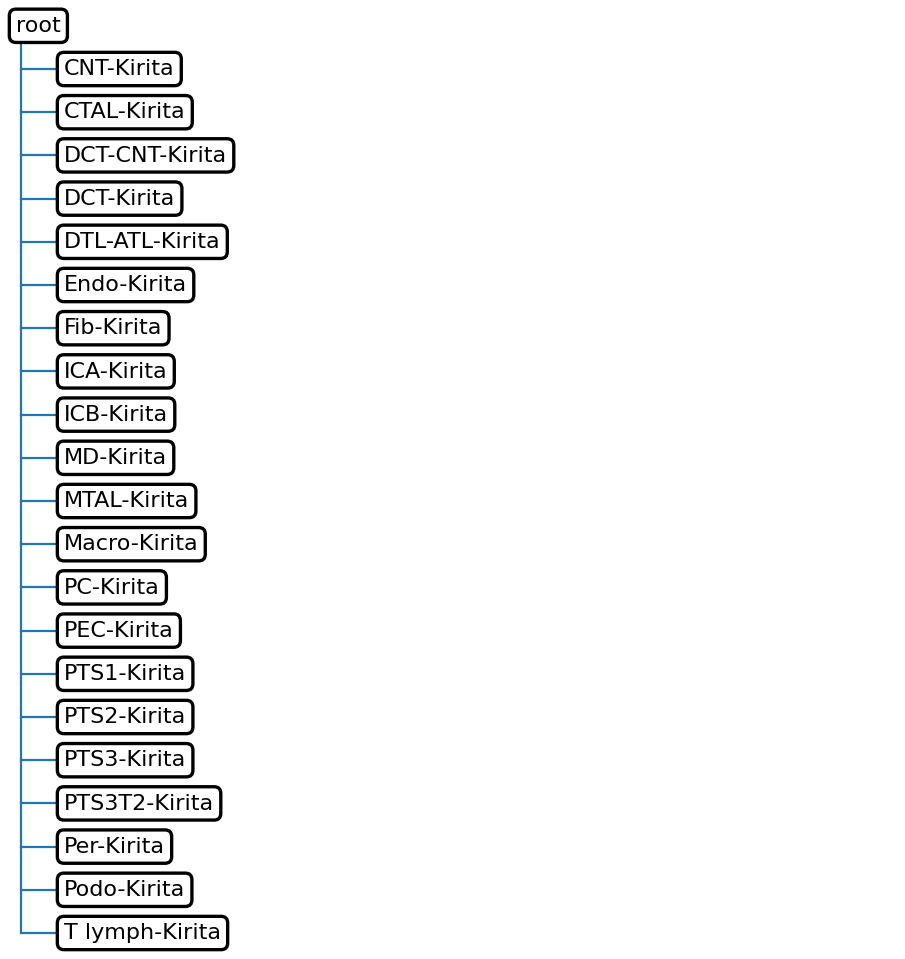


Adding dataset Wu19 to the tree

Updated tree:


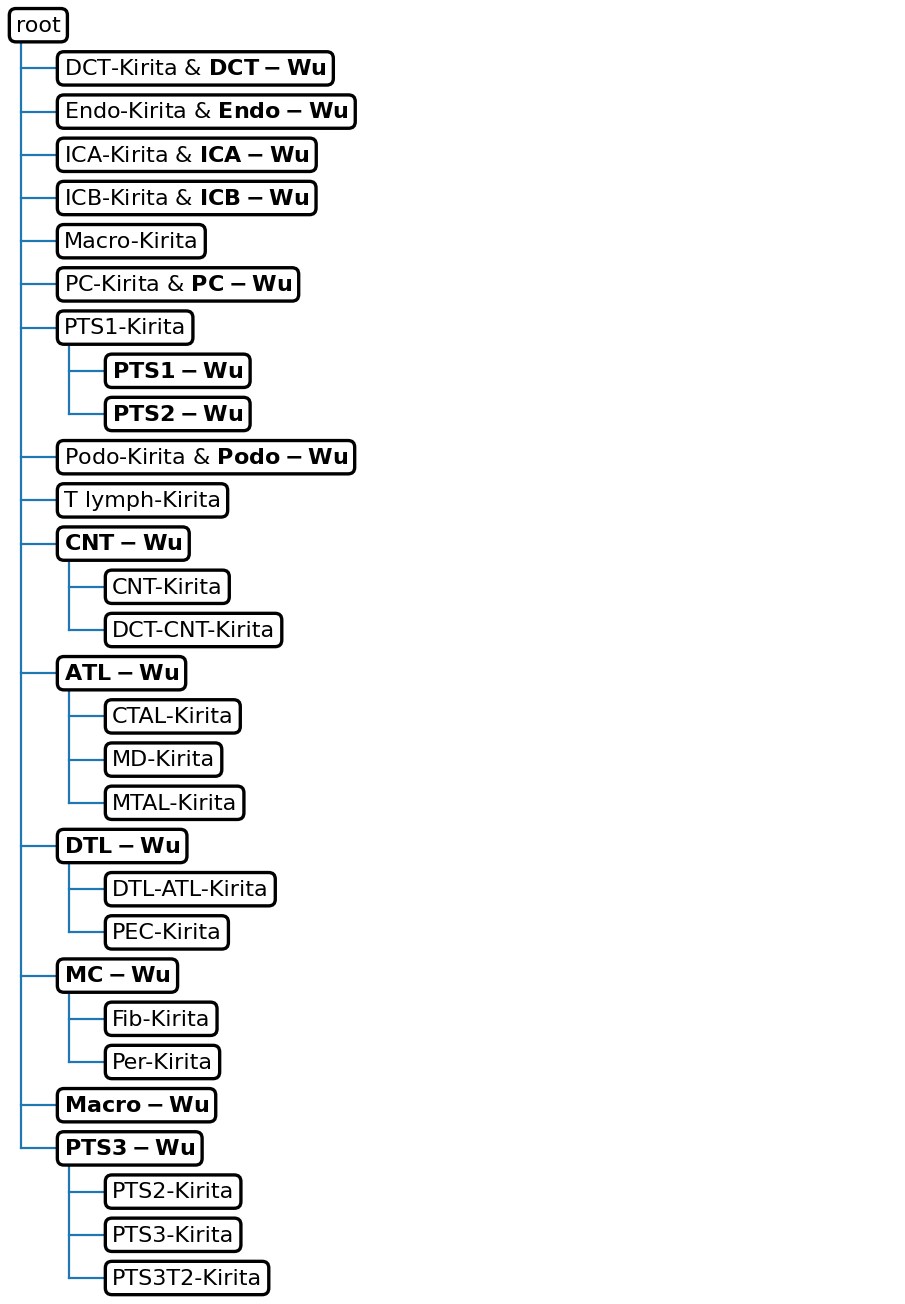


Adding dataset Janosevic21 to the tree


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


These populations are missing from the tree: 
['PTS1-Janosevic' 'PTS2-Janosevic']

Updated tree:


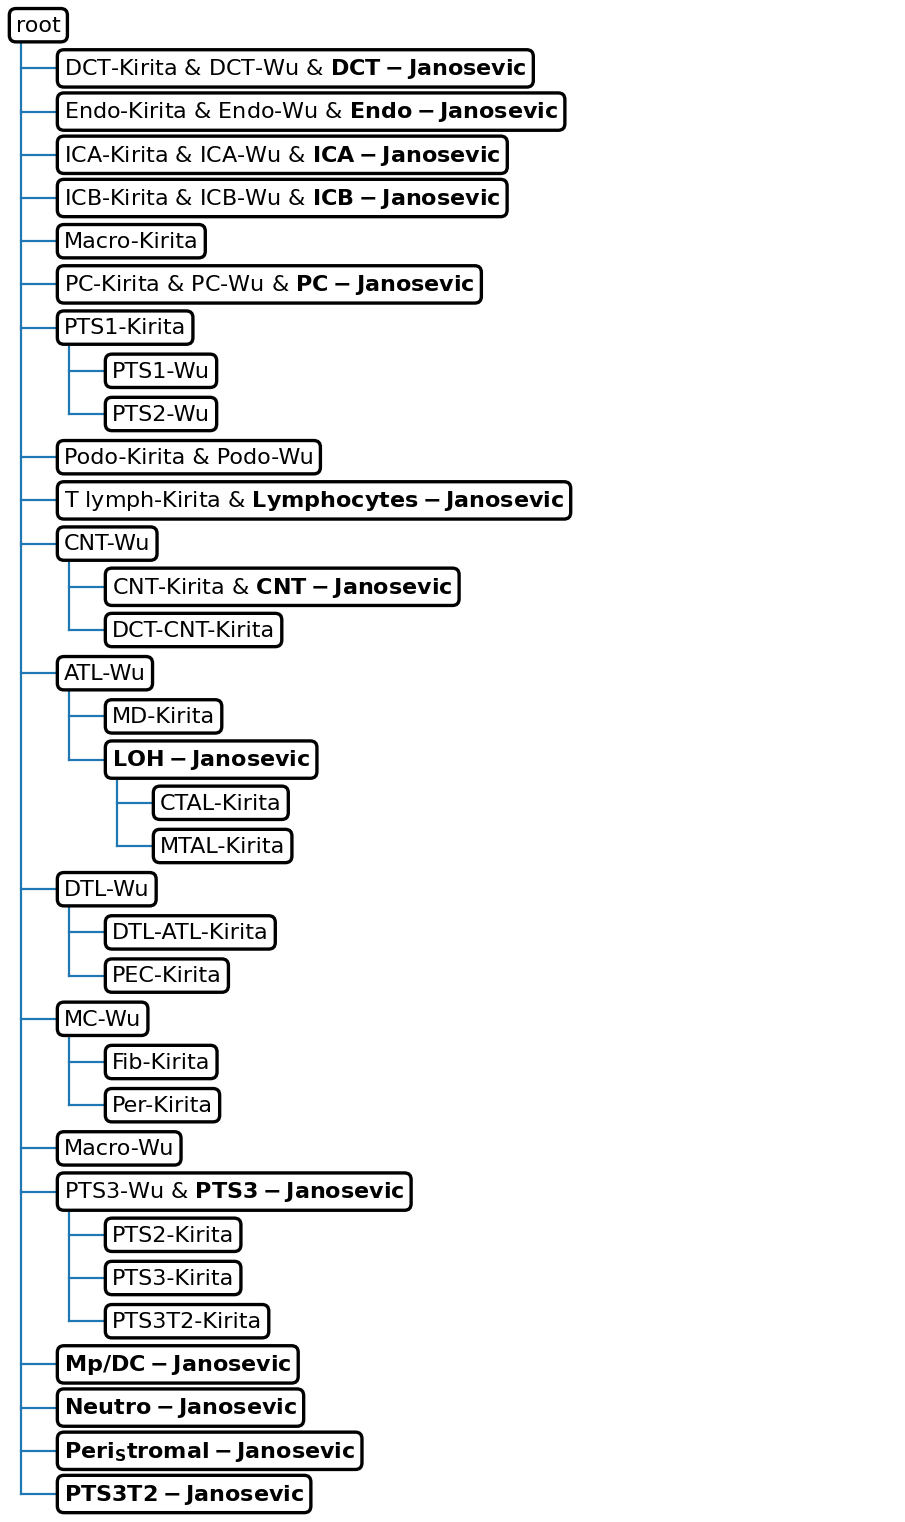


Adding dataset Park18 to the tree


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


These populations are missing from the tree: 
['PTS2-Park' 'PTS3-Park']

Updated tree:


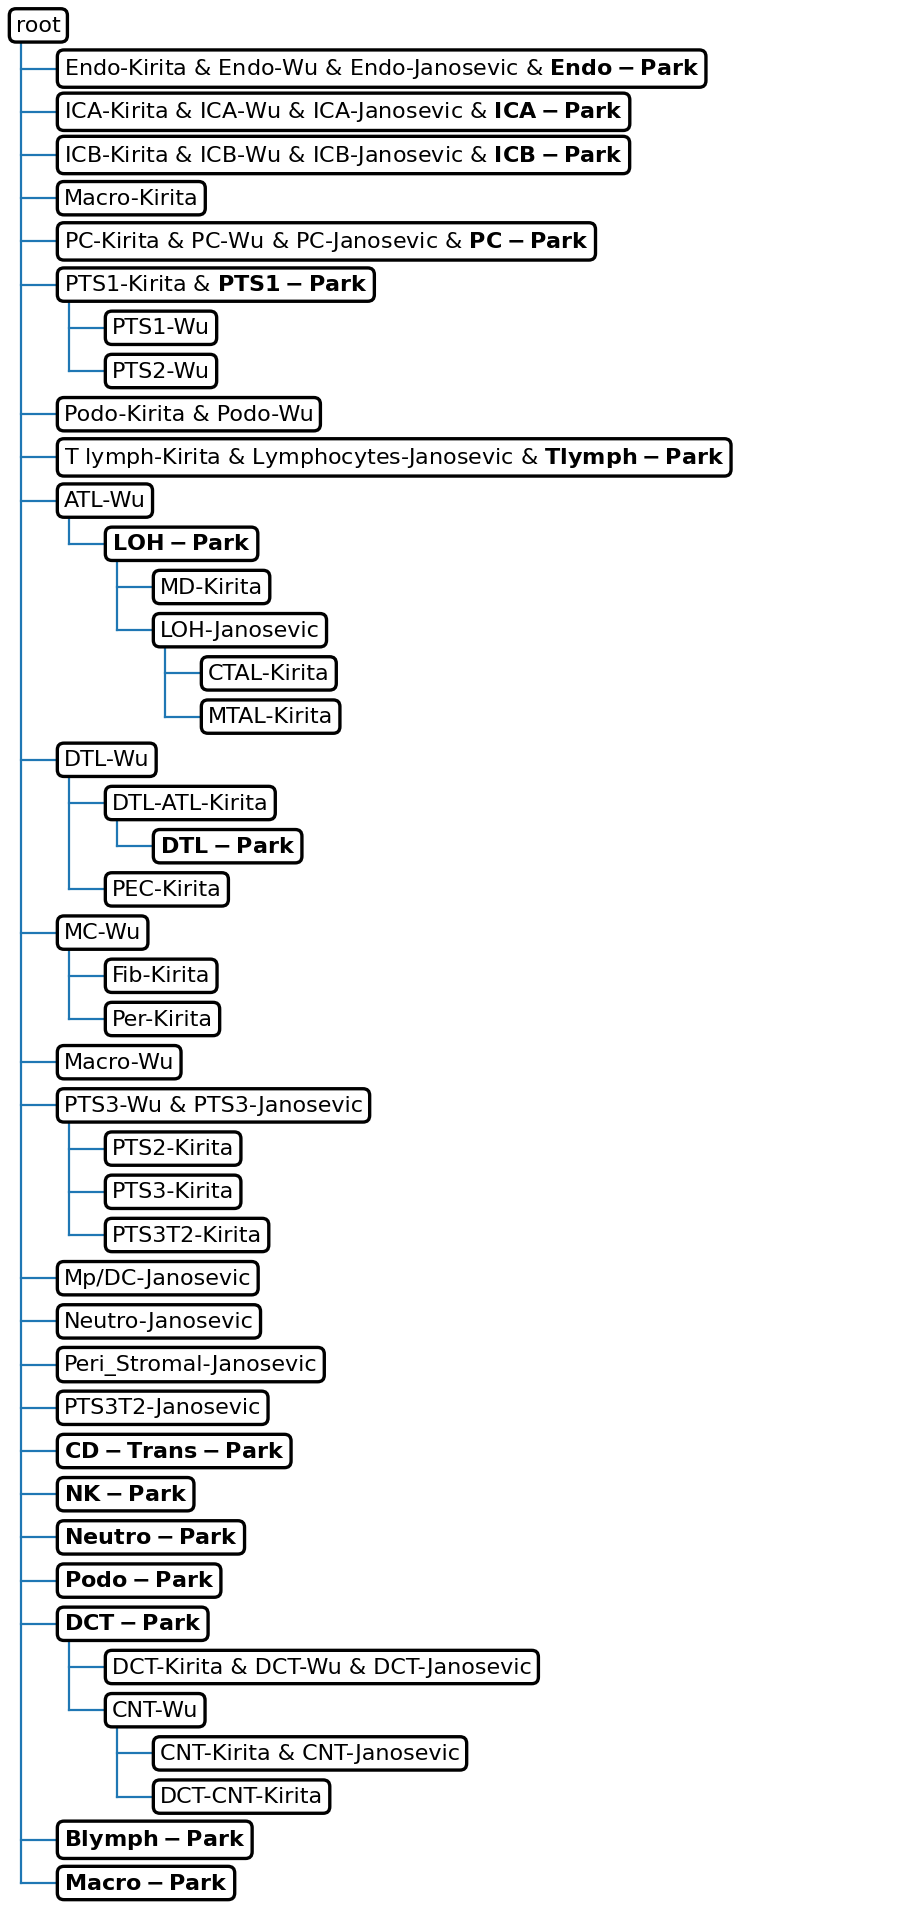


Adding dataset Dumas20 to the tree


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)



Updated tree:


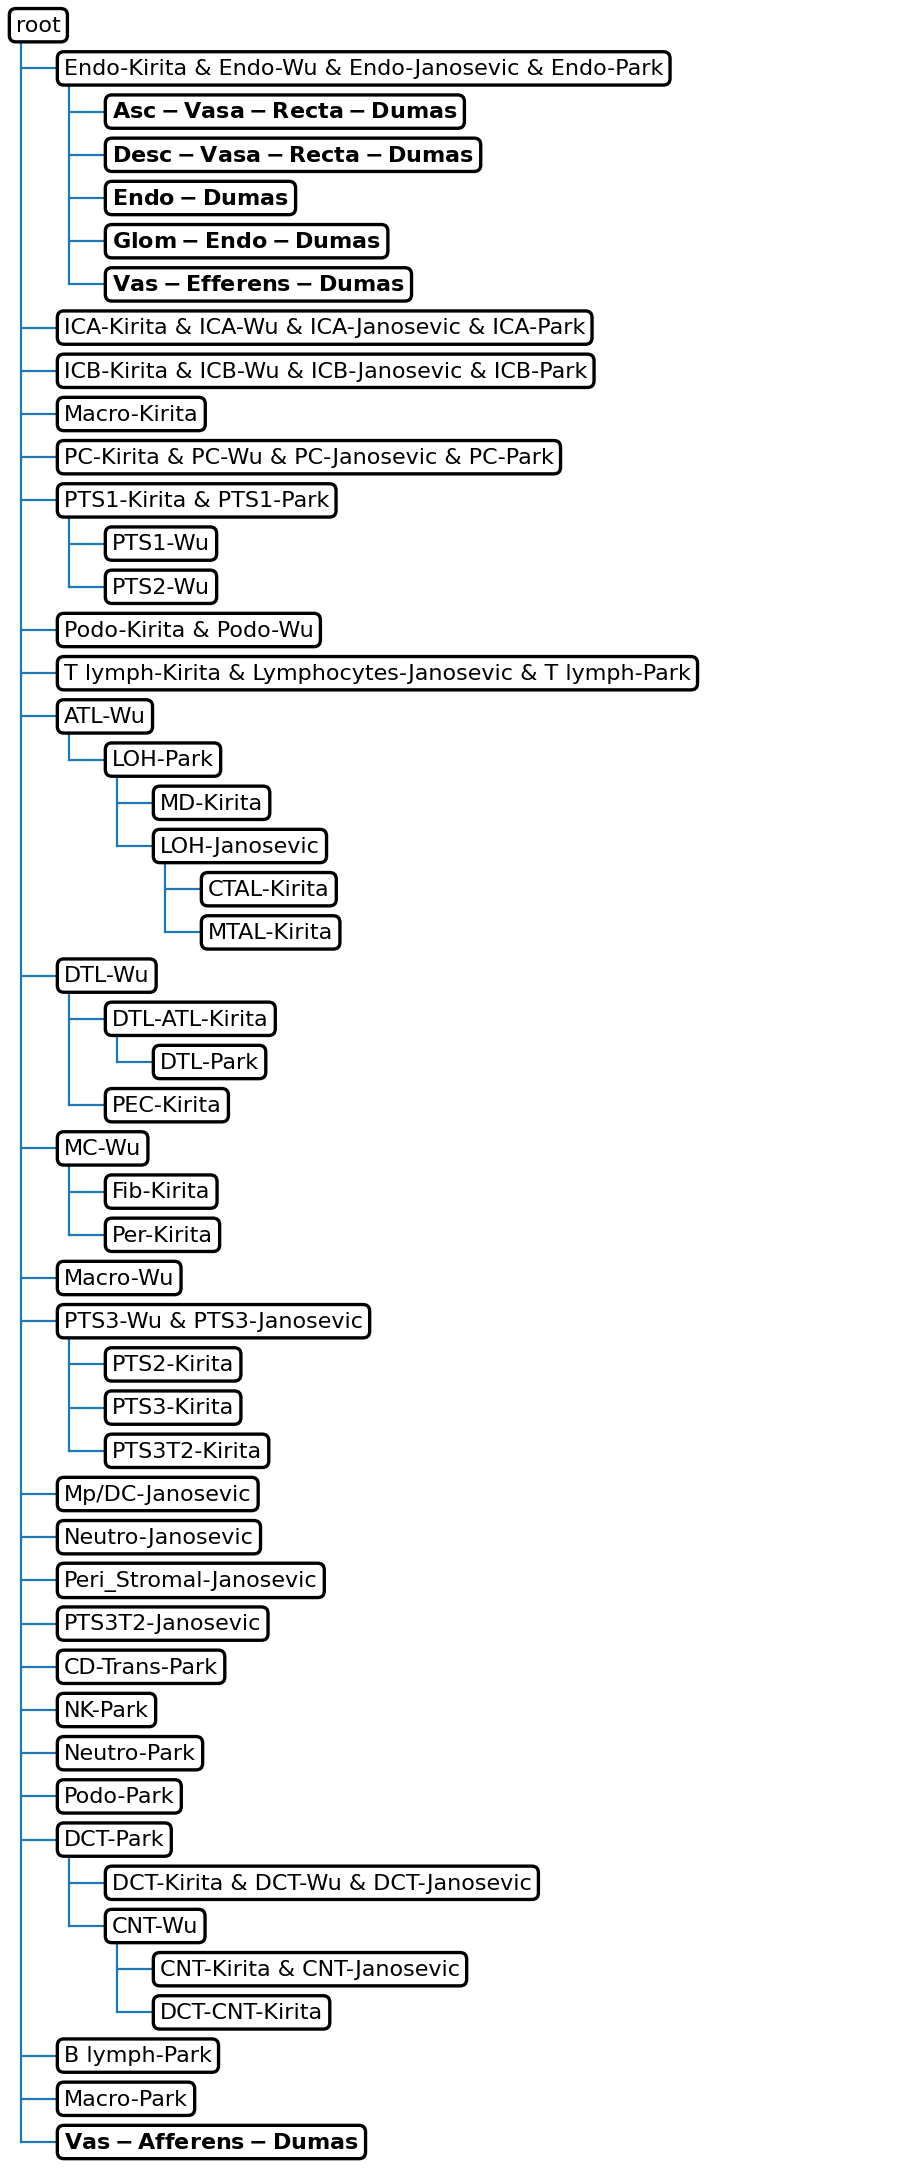

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [42]:
tree_ref, mp_ref = learn.learn_tree(data = ref_scHPL_X_scANVI , 
                batch_key = 'Origin',
                batch_order = ['Kirita20', 'Wu19', 'Janosevic21', 'Park18', 'Dumas20'],
                cell_type_key='Celltype_finest_batch',
                classifier = 'knn')

In [54]:
# store latent repr in own anndata object

# querydata = pd.DataFrame(data = query_scHPL.obsm["X_scANVI"], index = query_scHPL.obs_names)
query_scHPL_X_scANVI = query_scHPL.obsm['X_scANVI']

## Predict labels with tree_occ_2
query_predicted_knn = predict.predict_labels(query_scHPL_X_scANVI, tree_ref)

Time to make predictions with scHPL on a normal desktop: 164.18100357055664


In [57]:
pred_miao_knn = pd.DataFrame(data=query_predicted_knn, index=query_scHPL.obs.index)
pred_miao_knn.to_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_scHPL_SCANVI_kNN.csv")

### scHPL SVM

### Predictions by scHPL (my reference)

In [5]:
pred_miao_knn = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_scHPL_SCANVI_kNN.csv", index_col=0) #kNN

### Predictions by Azimuth (Human; anchors)

In [6]:
azimuth_hubmap_labels_SCANVI = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_Hubmap_anchors_SCANVI.tsv", sep='\t', index_col='cell')

In [7]:
azimuth_hubmap_labels_SCANVI.groupby('predicted.annotation.l2').mean()

predicted.annotation.l2.score  \
predicted.annotation.l2                                                             
Afferent / Efferent Arteriole Endothelial                                0.422514   
B                                                                        0.629019   
Classical Dendritic                                                      0.240062   
Connecting Tubule                                                        0.692855   
Cortical Collecting Duct Intercalated Type A                             0.354640   
Cortical Collecting Duct Principal                                       0.618750   
Cortical Thick Ascending Limb                                            0.726465   
Descending Thin Limb Type 1                                              0.321791   
Descending Thin Limb Type 2                                              0.354461   
Descending Vasa Recta Endothelial                                        0.468691   
Distal Convoluted Tubule                                                 0.881987   
Fibroblast                                                               0.472626   
Glomerular Capillary Endothelial                                         0.851059   
Inner Medullary Collecting Duct                                          0.337839   
Intercalated Type B                                                      0.496748   
M2 Macrophage                                                            0.548227   
Macula Densa                                                             0.669193   
Medullary Thick Ascending Limb                                           0.573596   
Monocyte-derived                                                         0.306483   
Natural Killer T                                                         0.647581   
Neutrophil                                                               0.744243   
Non-classical monocyte                                                   0.555080   
Outer Medullary Collecting Duct Intercalated Ty...                       0.610777   
Papillary Tip Epithelial                                                 0.412829   
Peritubular Capilary Endothelial                                         0.402132   
Plasmacytoid Dendritic                                                   0.362958   
Podocyte                                                                 0.960964   
Proximal Tubule Epithelial Segment 1                                     0.601820   
Proximal Tubule Epithelial Segment 2                                     0.346934   
Proximal Tubule Epithelial Segment 3                                     0.477126   
T                                                                        0.727124   

                                                    predicted.annotation.l1.score  \
predicted.annotation.l2                                                             
Afferent / Efferent Arteriole Endothelial                                0.990115   
B                                                                        0.921860   
Classical Dendritic                                                      0.855732   
Connecting Tubule                                                        0.695243   
Cortical Collecting Duct Intercalated Type A                             0.424550   
Cortical Collecting Duct Principal                                       0.731657   
Cortical Thick Ascending Limb                                            0.943440   
Descending Thin Limb Type 1                                              0.605293   
Descending Thin Limb Type 2                                              0.449123   
Descending Vasa Recta Endothelial                                        0.975540   
Distal Convoluted Tubule                                                 0.883597   
Fibroblast                                                               0.665106   
Glomerular Capillary Endothelial                        

### Predictions by Azimuth (Mouse; anchors, my atlas)

In [8]:
azimuth_atlas_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_anchors_SCANVI.tsv", sep='\t', index_col=0)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
azimuth_atlas_labels.groupby('predicted.id').mean().to_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_anchors_SCANVI_meanscores.tsv", sep='\t')

### True labels, after manual curation

In [10]:
atlas_reference = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_int_curated_SCVI.h5ad")

In [11]:
groups = atlas_reference.obs.groupby('Origin').indices

In [12]:
miao = atlas_reference[groups['Miao21']]
miao_labels = pd.DataFrame(data = miao.obs['Celltype_Susztak'].values, index=miao.obs.index)
miao_labels.to_csv("/exports/humgen/cnovellarausell/KidneyAtlas/csvs/Miao_True_Labels_SCANVI.csv")

### Accuracy scores

#### scHPL:  classical F1 

In [10]:
pred_labels_knn = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_scHPL_SCANVI_kNN.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1) #kNN
miao_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/csvs/Miao_True_Labels_SCANVI.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1)

In [11]:
pred_labels_scoring_knn = pred_labels_knn.copy()
miao_labels_scoring = miao_labels.copy()

In [12]:
miao_labels_scoring['cell_type'] = miao_labels_scoring['cell_type'].str.rsplit("-", 1).str[0]
pred_labels_scoring_knn['cell_type'] = pred_labels_scoring_knn['cell_type'].str.rsplit("-", 1).str[0]

In [13]:
new_index = miao_labels_scoring.index.to_series().str.rsplit("-", 1).str[0]
miao_labels_scoring.rename(index=new_index, inplace=True)

In [14]:
pred_labels_scoring_knn = pred_labels_scoring_knn[pred_labels_scoring_knn.index.isin(miao_labels_scoring.index.to_list())].copy()

In [15]:
mapping = {
    'Vas-Afferens': 'Endo',
    'Vas-Efferens': 'Endo',
    'Glom-Endo': 'Endo',
    'Desc-Vasa-Recta': 'Endo',
    'CTAL': 'LOH',
    'MTAL': 'LOH',
    'DCT-CNT': 'DCT',
    'DTL-ATL': 'LOH',
    'ATL': 'LOH',
    'DTL-LOH': 'LOH'}

for k, v in mapping.items():
    pred_labels_scoring_knn['cell_type'] = pred_labels_scoring_knn['cell_type'].str.replace(k,v).copy()

In [18]:
# Cell-type specific F1 score
F1_ct_scHPL_Atlas_knn = {}
F1_ct_scHPL_Atlas_svm = {}

# We need to filter the predicted set with the !barcodes of true set, not with the cell type label
for i in set(miao_labels_scoring.values.flatten()):
    true_barcodes = miao_labels_scoring[miao_labels_scoring['cell_type'] == i].index
    F1_ct_scHPL_Atlas_knn[i] = f1_score(miao_labels_scoring[miao_labels_scoring['cell_type'] == i].values, pred_labels_scoring_knn.loc[list(true_barcodes)].values, average='micro', labels=list(set(miao_labels_scoring.values.flatten())))
    F1_ct_scHPL_Atlas_svm[i] = f1_score(miao_labels_scoring[miao_labels_scoring['cell_type'] == i].values, pred_labels_scoring_svm.loc[list(true_barcodes)].values, average='micro', labels=list(set(miao_labels_scoring.values.flatten())))

In [1]:
print(np.median(np.array(list(F1_ct_scHPL_Atlas_knn.values()))))

0.8487688375535972


In [18]:
F1_ct_scHPL_Atlas_knn, F1_ct_scHPL_Atlas_svm

({'ICA': 0.7439024390243902,
  'Podo': 0.393939393939394,
  'T lymph': 0.8174322732626621,
  'LOH': 0.9515072083879422,
  'PTS2': 0.9022256039566292,
  'PTS3': 0.05632772494513533,
  'ICB': 0.8892045454545455,
  'PTS1': 0.42119089316987746,
  'DCT': 0.905183991404781,
  'PC': 0.8801054018445323,
  'Neutro': 0.0,
  'Endo': 0.9831460674157304,
  'PTS3T2': 0.888888888888889,
  'Macro': 0.6521739130434784},
 {'ICA': 0.6818181818181819,
  'Podo': 0.1724137931034483,
  'T lymph': 0.8571428571428571,
  'LOH': 0.9263721552878179,
  'PTS2': 0.22172123113115075,
  'PTS3': 0.051558291650634865,
  'ICB': 0.9372384937238494,
  'PTS1': 0.8213644524236984,
  'DCT': 0.8845155118217849,
  'PC': 0.8232044198895028,
  'Neutro': 0.0,
  'Endo': 0.9806094182825484,
  'PTS3T2': 0.8113207547169811,
  'Macro': 0.7647058823529411})

In [104]:
with open('F1_ct_scHPL_kNN_SCANVI.json', 'w') as fout_knn:
    json.dump(F1_ct_scHPL_Atlas_knn, fout_knn)

#### Azimuth, hubmap F1 scores 

In [20]:
azimuth_hubmap_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_Hubmap_anchors_SCANVI.tsv", sep='\t', index_col='cell')
miao_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/csvs/Miao_True_Labels_SCANVI.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1)

In [21]:
# Azimuth: match barcodes between original cells and those predicted by Azimuth (different number of cells due to sligthly different preprocessing between Seurat and Scanpy)
new_index = azimuth_hubmap_labels.index.to_series().str.cat(['-3']*len(azimuth_hubmap_labels.index))
azimuth_hubmap_labels.rename(index=new_index, inplace=True)
azimuth_hubmap_labels = azimuth_hubmap_labels[azimuth_hubmap_labels.index.isin(miao_labels.index.to_list())]

- match labels so I can compute an F1 score

In [23]:
azimuth_hubmap_labels_scoring = azimuth_hubmap_labels.copy()
miao_labels_scoring = miao_labels.copy()

In [24]:
set(miao_labels['cell_type'])

{'DCT-Miao',
 'Endo-Miao',
 'ICA-Miao',
 'ICB-Miao',
 'LOH-Miao',
 'Macro-Miao',
 'Neutro-Miao',
 'PC-Miao',
 'PTS1-Miao',
 'PTS2-Miao',
 'PTS3-Miao',
 'PTS3T2-Miao',
 'Podo-Miao',
 'T lymph-Miao'}

In [25]:
mapping = {
    'B': 'B lymph-Susztak',
    'Glomerular Capillary Endothelial': 'Endo-Susztak',
    'Afferent / Efferent Arteriole Endothelial': 'Endo-Susztak',
    'Ascending Vasa Recta Endothelial': 'Endo-Susztak',
    'Descending Vasa Recta Endothelial ': 'Endo-Susztak',
    'Classical Dendritic': 'Dendritic cell',
    'Connecting Tubule': 'CNT',
    'Cortical Collecting Duct Principal': 'PC-Susztak',
    'Cortical Collecting Duct Intercalated Type A': 'ICA-Susztak',
    'Cortical Thick Ascending Limb': 'LOH-Susztak',
    'Descending Thin Limb Type 1': 'DTL1',
    'Descending Thin Limb Type 2': 'DTL2',
    'Distal Convoluted Tubule': 'DCT-Susztak',
    'Inner Medullary Collecting Duct': 'IM-CD',
    'Intercalated Type B': 'ICB-Susztak',
    'M2 Macrophage': 'Macro-Susztak',
    'Macula Densa': 'MD',
    'Medullary Fibroblast': 'M-Fib',
    'Medullary Thick Ascending Limb': 'LOH-Susztak',
    'Monocyte-derived': 'Mono',
    'Non-classical monocyte': 'Mono 2',
    'Natural Killer T': 'NK',
    'Neutrophil': 'Neutro-Susztak',
    'Outer Medullary Collecting Duct Intercalated Type A': 'ICA-Susztak',
    'Papillary Tip Epithelial': 'PTE',
    'Parietal Epithelial': 'PEC',
    'Peritubular Capilary Endothelial ': 'PCE',
    'Podocyte': 'Podo-Susztak',
    'Proximal Tubule Epithelial Segment 1': 'PTS1-Susztak',
    'Proximal Tubule Epithelial Segment 2': 'PTS2-Susztak',
    'Proximal Tubule Epithelial Segment 3': 'PTS3-Susztak',
    'T': 'T lymph-Susztak'}

for k, v in mapping.items():
    azimuth_hubmap_labels_scoring['predicted.annotation.l2'] = azimuth_hubmap_labels_scoring['predicted.annotation.l2'].replace(k,v).copy()

In [26]:
miao_labels_scoring['cell_type'] = miao_labels_scoring['cell_type'].str.rsplit("-", 1).str[0]
azimuth_hubmap_labels_scoring['predicted.annotation.l2'] = azimuth_hubmap_labels_scoring['predicted.annotation.l2'].str.rsplit("-",1).str[0]

In [28]:
# Cell-type specific F1 score
F1_ct_Azimuth_Human = {}

# We need to filter the predicted set with the !barcodes of true set, not with the cell type label
for i in set(miao_labels_scoring.values.flatten()):
    true_barcodes = miao_labels_scoring[miao_labels_scoring['cell_type'] == i].index
    F1_ct_Azimuth_Human[i] = f1_score(miao_labels_scoring[miao_labels_scoring['cell_type'] == i].values, azimuth_hubmap_labels_scoring['predicted.annotation.l2'].loc[list(true_barcodes)].values, average='micro', labels=list(set(miao_labels_scoring.values.flatten())))

In [68]:
F1_ct_Azimuth_Human

{'ICB': 0.4244897959183674,
 'Endo': 0.9378531073446328,
 'Neutro': 0.7714285714285715,
 'T lymph': 0.7523148148148148,
 'PTS1': 0.9663461538461537,
 'PTS3T2': 0.0,
 'LOH': 0.8523206751054853,
 'Macro': 0.19909502262443443,
 'Podo': 0.9433962264150944,
 'PTS2': 0.0032809936723693462,
 'PC': 0.5397301349325337,
 'ICA': 0.6204986149584488,
 'PTS3': 0.30554507732930974,
 'DCT': 0.9587802041607443}

In [69]:
print(np.median(np.array(list(F1_ct_Azimuth_Human.values()))))

0.6864067148866317


In [116]:
with open('F1_ct_Azimuth_Human_SCANVI.json', 'w') as fout:
    json.dump(F1_ct_Azimuth_Human, fout)

#### Azimuth, atlas F1 scores 

In [29]:
azimuth_atlas_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_anchors_SCANVI.tsv", sep='\t', index_col=0)
miao_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/csvs/Miao_True_Labels_SCANVI.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1)

In [30]:
# Azimuth: match barcodes between original cells and those predicted by Azimuth (different number of cells due to sligthly different preprocessing between Seurat and Scanpy)
new_index = azimuth_atlas_labels.index.to_series().str.cat(['-3']*len(azimuth_atlas_labels.index))
azimuth_atlas_labels.rename(index=new_index, inplace=True)
azimuth_atlas_labels = azimuth_atlas_labels[azimuth_atlas_labels.index.isin(miao_labels.index.to_list())]

In [31]:
azimuth_atlas_labels_scoring = azimuth_atlas_labels.copy()
miao_labels_scoring = miao_labels.copy()

In [32]:
mapping = {
    'Glom-Endo': 'Endo',
    'ATL': 'LOH',
    'DTL': 'LOH'}

for k, v in mapping.items():
    azimuth_atlas_labels_scoring['predicted.id'] = azimuth_atlas_labels_scoring['predicted.id'].replace(k,v).copy()

In [33]:
miao_labels_scoring['cell_type'] = miao_labels_scoring['cell_type'].str.rsplit("-", 1).str[0]

In [35]:
# Cell-type specific F1 score
F1_ct_Azimuth_Atlas = {}

# We need to filter the predicted set with the !barcodes of true set, not with the cell type label
for i in set(miao_labels_scoring.values.flatten()):
    true_barcodes = miao_labels_scoring[miao_labels_scoring['cell_type'] == i].index
    F1_ct_Azimuth_Atlas[i] = f1_score(miao_labels_scoring[miao_labels_scoring['cell_type'] == i].values, azimuth_atlas_labels_scoring['predicted.id'].loc[list(true_barcodes)].values, average='micro', labels=list(set(miao_labels_scoring.values.flatten())))

In [43]:
F1_ct_Azimuth_Atlas

{'ICA': 0.6410958904109588,
 'Podo': 0.9811320754716981,
 'T lymph': 0.896551724137931,
 'LOH': 0.9445843828715366,
 'PTS2': 0.29408983451536647,
 'PTS3': 0.5008996041741633,
 'ICB': 0.9646739130434783,
 'PTS1': 0.8146701388888887,
 'DCT': 0.9527620030975735,
 'PC': 0.8224299065420562,
 'Neutro': 0.9041095890410958,
 'Endo': 0.9217877094972067,
 'PTS3T2': 0.864406779661017,
 'Macro': 0.8108108108108107}

In [77]:
print(np.median(np.array(list(F1_ct_Azimuth_Atlas.values()))))

0.880479251899474


In [126]:
with open('F1_ct_Azimuth_Atlas_SCANVI_v2.json', 'w') as fout:
    json.dump(F1_ct_Azimuth_Atlas, fout)

### Grouped barplot

In [36]:
from collections import defaultdict

dd = defaultdict(list)
for d in (F1_ct_scHPL_Atlas_knn,  F1_ct_Azimuth_Atlas, F1_ct_Azimuth_Human): 
    for key, value in d.items():
        dd[key].append(value)

print(dd)

defaultdict(<class 'list'>, {'PC': [0.8801054018445323, 0.8224299065420562, 0.5397301349325337], 'PTS1': [0.42119089316987746, 0.8146701388888887, 0.9663461538461537], 'Podo': [0.393939393939394, 0.9811320754716981, 0.9433962264150944], 'Macro': [0.6521739130434784, 0.8108108108108107, 0.19909502262443443], 'Endo': [0.9831460674157304, 0.9217877094972067, 0.9378531073446328], 'PTS3T2': [0.888888888888889, 0.864406779661017, 0.0], 'PTS3': [0.05632772494513533, 0.5008996041741633, 0.30554507732930974], 'PTS2': [0.9022256039566292, 0.29408983451536647, 0.0032809936723693462], 'LOH': [0.9515072083879422, 0.9445843828715366, 0.8523206751054853], 'ICA': [0.7439024390243902, 0.6410958904109588, 0.6204986149584488], 'ICB': [0.8892045454545455, 0.9646739130434783, 0.4244897959183674], 'Neutro': [0.0, 0.9041095890410958, 0.7714285714285715], 'T lymph': [0.8174322732626621, 0.896551724137931, 0.7523148148148148], 'DCT': [0.905183991404781, 0.9527620030975735, 0.9587802041607443]})


In [37]:
dd_df = pd.DataFrame.from_dict(dd, orient='index')
dd_df.reset_index(level=0, inplace=True)
dd_df.rename(columns={dd_df.columns[0]: 'Cell_type', dd_df.columns[1]: 'scHPL(kNN) + MKA*', dd_df.columns[2]: 'Azimuth + MKA*', dd_df.columns[3]: 'Azimuth + Human ref'}, inplace=True)

In [38]:
dd_df = dd_df.melt(id_vars=["Cell_type"], 
        var_name="Method", 
        value_name="F1_Score").copy()

In [39]:
dd_df.to_csv("grouped_barplot.csv")

In [86]:
f1_scores_df = pd.DataFrame({"model": ["scHPL(kNN) + MKA*", "Azimuth + MKA*", "Azimuth + Human ref"], "f1": [0.85, 0.88, 0.68]})

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
f1_scores_df

model    f1
0    scHPL(kNN) + MKA*  0.85
1       Azimuth + MKA*  0.88
2  Azimuth + Human ref  0.68

In [152]:
plt.show()

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


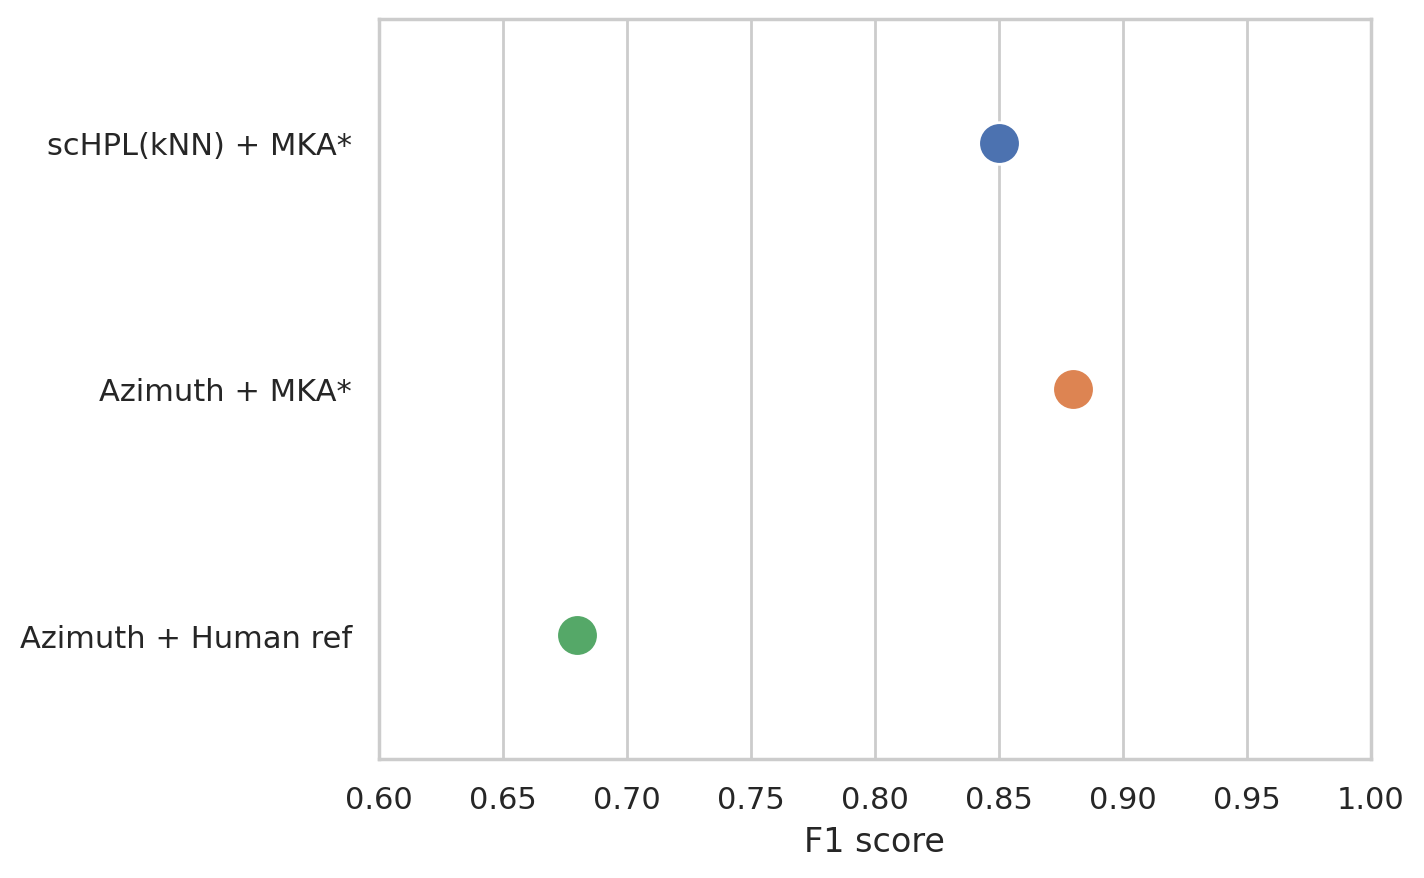

In [154]:
sns.set_theme(style="whitegrid")
g = sns.stripplot(x=f1_scores_df["f1"], y=f1_scores_df['model'], palette='deep', linewidth=1, edgecolor="w", orient="h", jitter=False, size=15)
g.set(xlim=(0.6, 1), xlabel="F1 score", ylabel="")
plt.savefig('F1_per_model_SCANVI.svg',bbox_inches="tight")

In [43]:
dd_df['Cell_type'] = pd.Categorical(dd_df['Cell_type'], ["PTS1", "PTS2", "PTS3", "PTS3T2", "LOH", "ICA", "ICB", "PC", "Podo","DCT", "Macro", "Neutro", "T lymph", "Endo"])
dd_df.sort_values(by='Cell_type', inplace=True)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


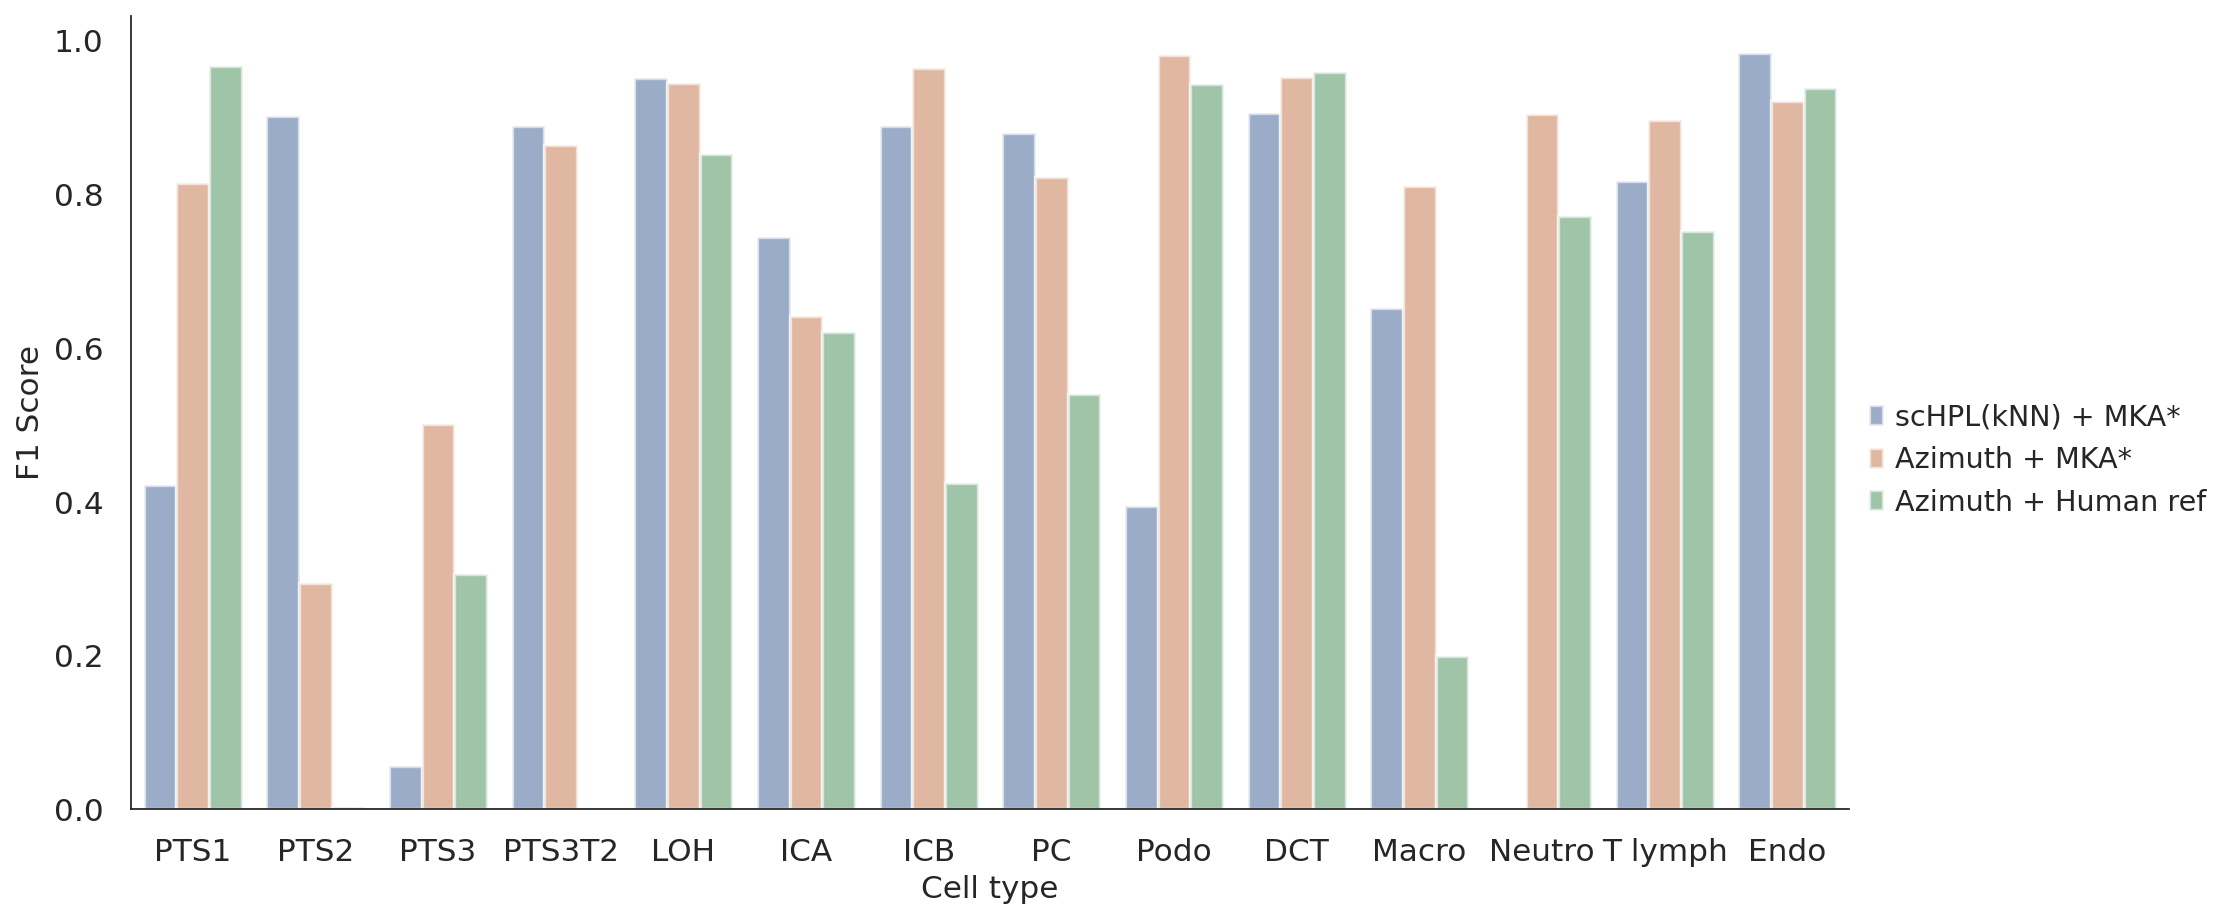

In [44]:
sns.set_style("white")

g = sns.catplot(
    data=dd_df, kind="bar",
    x="Cell_type", y="F1_Score", hue="Method",
    ci="sd", palette='deep', alpha=.6, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Cell type", "F1 Score")
g.legend.set_title("")
g.despine()
plt.savefig('F1_per_celltype_SCANVI.pdf')

### Compute confusion matrices

In [79]:
pred_labels_knn = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_scHPL_SCANVI_kNN.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1) #kNN
azimuth_hubmap_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_Hubmap_anchors_SCANVI.tsv", sep='\t', index_col='cell')
azimuth_atlas_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/predicted_celltypes/predicted_Miao_pMKA_anchors_SCANVI.tsv", sep='\t', index_col=0)
miao_labels = pd.read_csv("/exports/humgen/cnovellarausell/KidneyAtlas/csvs/Miao_True_Labels_SCANVI.csv", index_col=0, names=['barcode','cell_type'], header=None, skiprows=1)

In [80]:
miao_labels['cell_type'] = miao_labels['cell_type'].str.rsplit("-", 1).str[0]
pred_labels_knn['cell_type'] = pred_labels_knn['cell_type'].str.rsplit("-", 1).str[0]
azimuth_atlas_labels['cell_type'] = azimuth_atlas_labels['predicted.id']
azimuth_hubmap_labels['cell_type'] = azimuth_hubmap_labels['predicted.annotation.l2']

In [81]:
new_index = miao_labels.index.to_series().str.rsplit("-", 1).str[0]
miao_labels.rename(index=new_index, inplace=True)

In [82]:
miao_labels.shape, pred_labels_knn.shape, azimuth_atlas_labels.shape, azimuth_hubmap_labels.shape

((15325, 1), (22813, 1), (22813, 4), (22813, 8))

In [83]:
pred_labels_knn = pred_labels_knn[pred_labels_knn.index.isin(miao_labels.index.to_list())].copy()

In [84]:
# Azimuth: match barcodes between original cells and those predicted by Azimuth (different number of cells due to sligthly different preprocessing between Seurat and Scanpy)
azimuth_atlas_labels = azimuth_atlas_labels[azimuth_atlas_labels.index.isin(miao_labels.index.to_list())]

In [85]:
# Azimuth: match barcodes between original cells and those predicted by Azimuth (different number of cells due to sligthly different preprocessing between Seurat and Scanpy)
azimuth_hubmap_labels = azimuth_hubmap_labels[azimuth_hubmap_labels.index.isin(miao_labels.index.to_list())]

In [59]:
miao_labels.shape, pred_labels_knn.shape, azimuth_atlas_labels.shape, azimuth_hubmap_labels.shape

((15325, 1), (15325, 1), (15325, 4), (15325, 8))

In [111]:
confmatrix_schpl = evaluate.confusion_matrix(miao_labels.values, pred_labels_knn.values)
confmatrix_schpl = confmatrix_schpl / np.sum(confmatrix_schpl.values, axis = 1, keepdims=True) #Normalize

In [86]:
confmatrix_az_hubmap = evaluate.confusion_matrix(miao_labels.values, azimuth_hubmap_labels['cell_type'].values)
confmatrix_az_hubmap = confmatrix_az_hubmap / np.sum(confmatrix_az_hubmap.values, axis = 1, keepdims=True) #Normalize

In [62]:
confmatrix_az_atlas = evaluate.confusion_matrix(miao_labels.values, azimuth_atlas_labels['cell_type'].values)
confmatrix_az_atlas = confmatrix_az_atlas / np.sum(confmatrix_az_atlas.values, axis = 1, keepdims=True) #Normalize

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Confusion matrix Azimuth workflow using atlas' reference

In [64]:
column_order_az_atlas = ['DCT', 'Endo', 'Glom-Endo', 'ICA', 'ICB', 'LOH', 'Macro', 'B lymph',  'Neutro', 'PC',  'CNT',  'PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo', 'T lymph', 'NK', 'DTL', 'DC', 'CD-Trans', 'ATL']

In [65]:
confmatrix_az_atlas = confmatrix_az_atlas.reindex(columns=column_order_az_atlas)
## Remove dataset addition -Dataset
new_index = confmatrix_az_atlas.index.to_series().str.split("-").str[0]
confmatrix_az_atlas.rename(index=new_index, inplace=True)

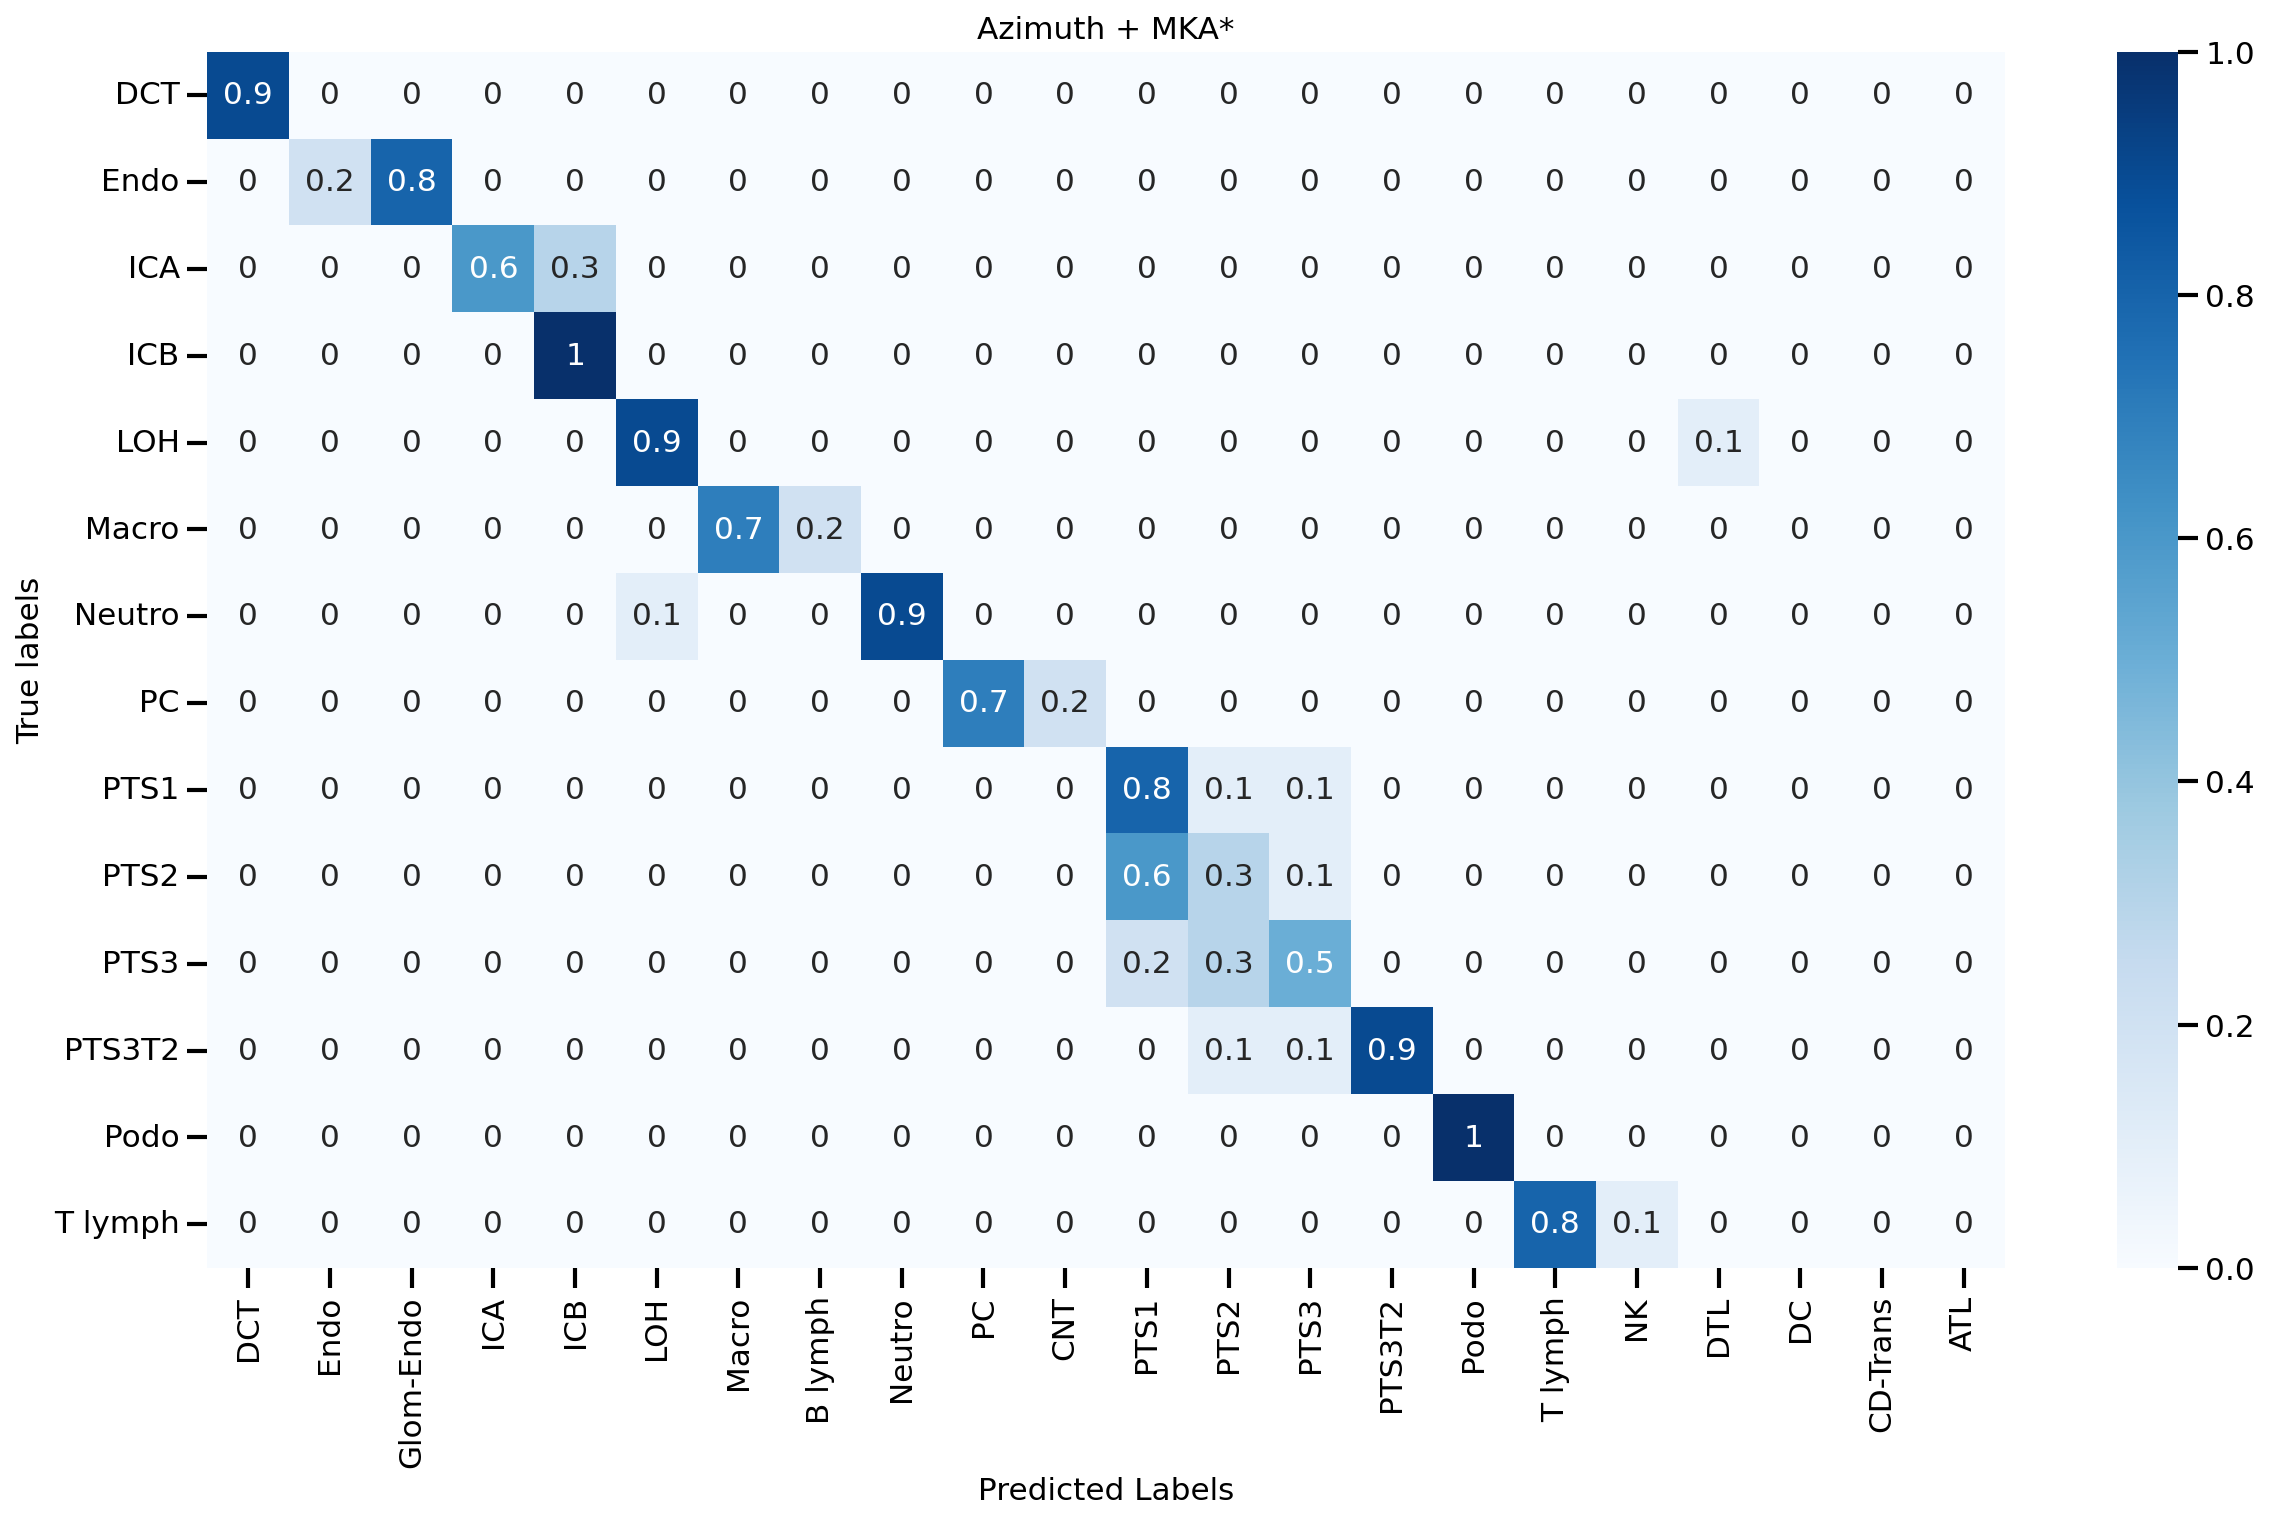

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
ax = sns.heatmap(round(confmatrix_az_atlas,1), vmin = 0, vmax = 1, annot=True, cmap='Blues')
ax.set_title(label='Azimuth + MKA*')
ax.set(xlabel='Predicted Labels', ylabel='True labels')
plt.savefig('confmatrix_MKA_Azimuth.svg')
plt.show()

- Azimuth workflow with hubmap reference

In [89]:
mapping = {
    'B': 'B lymph',
    'Glomerular Capillary Endothelial': 'GCE',
    'Afferent / Efferent Arteriole Endothelial': 'Art Endo',
    'Descending Vasa Recta Endothelial ': 'dVR Endo',
    'Classical Dendritic': 'Dendritic cell',
    'Connecting Tubule': 'CNT',
    'Cortical Collecting Duct Principal': 'PC',
    'Cortical Collecting Duct Intercalated Type A': 'C-ICA',
    'Cortical Thick Ascending Limb': 'CTAL',
    'Descending Thin Limb Type 1': 'DTL1',
    'Descending Thin Limb Type 2': 'DTL2',
    'Distal Convoluted Tubule': 'DCT',
    'Inner Medullary Collecting Duct': 'IM-CD',
    'Intercalated Type B': 'ICB',
    'M2 Macrophage': 'M2 Macro',
    'Macula Densa': 'MD',
    'Medullary Thick Ascending Limb': 'MTAL',
    'Monocyte-derived': 'Mono',
    'Non-classical monocyte': 'Mono 2',
    'Natural Killer T': 'NK',
    'Neutrophil': 'Neutro',
    'Outer Medullary Collecting Duct Intercalated Type A': 'OM-ICA',
    'Papillary Tip Epithelial': 'PTE',
    'Peritubular Capilary Endothelial ': 'PCE',
    'Podocyte': 'Podo',
    'Proximal Tubule Epithelial Segment 1': 'PTS1',
    'Proximal Tubule Epithelial Segment 2': 'PTS2',
    'Proximal Tubule Epithelial Segment 3': 'PTS3',
    'T': 'T lymph'}

confmatrix_az_hubmap.rename(columns=mapping, inplace=True)

In [90]:
column_order_az = ['DCT', 'GCE', 'OM-ICA', 'ICB', 'CTAL', 'MTAL', 'M2 Macro', 'Neutro', 'CNT', 'PC', 'PTS1', 'PTS2', 'PTS3', 'Podo', 'T lymph', 'Art Endo', 'Dendritic cell', 'DTL1', 'DTL2',  'dVR Endo', 'IM-CD', 'MD', 'Mono', 'NK', 'Mono 2', 'PTE', 'PCE', 'B lymph', 'C-ICA']

In [91]:
confmatrix_az_hubmap = confmatrix_az_hubmap.reindex(columns=column_order_az)
## Remove dataset addition -Dataset
new_index = confmatrix_az_hubmap.index.to_series().str.split("-").str[0]
confmatrix_az_hubmap.rename(index=new_index, inplace=True)

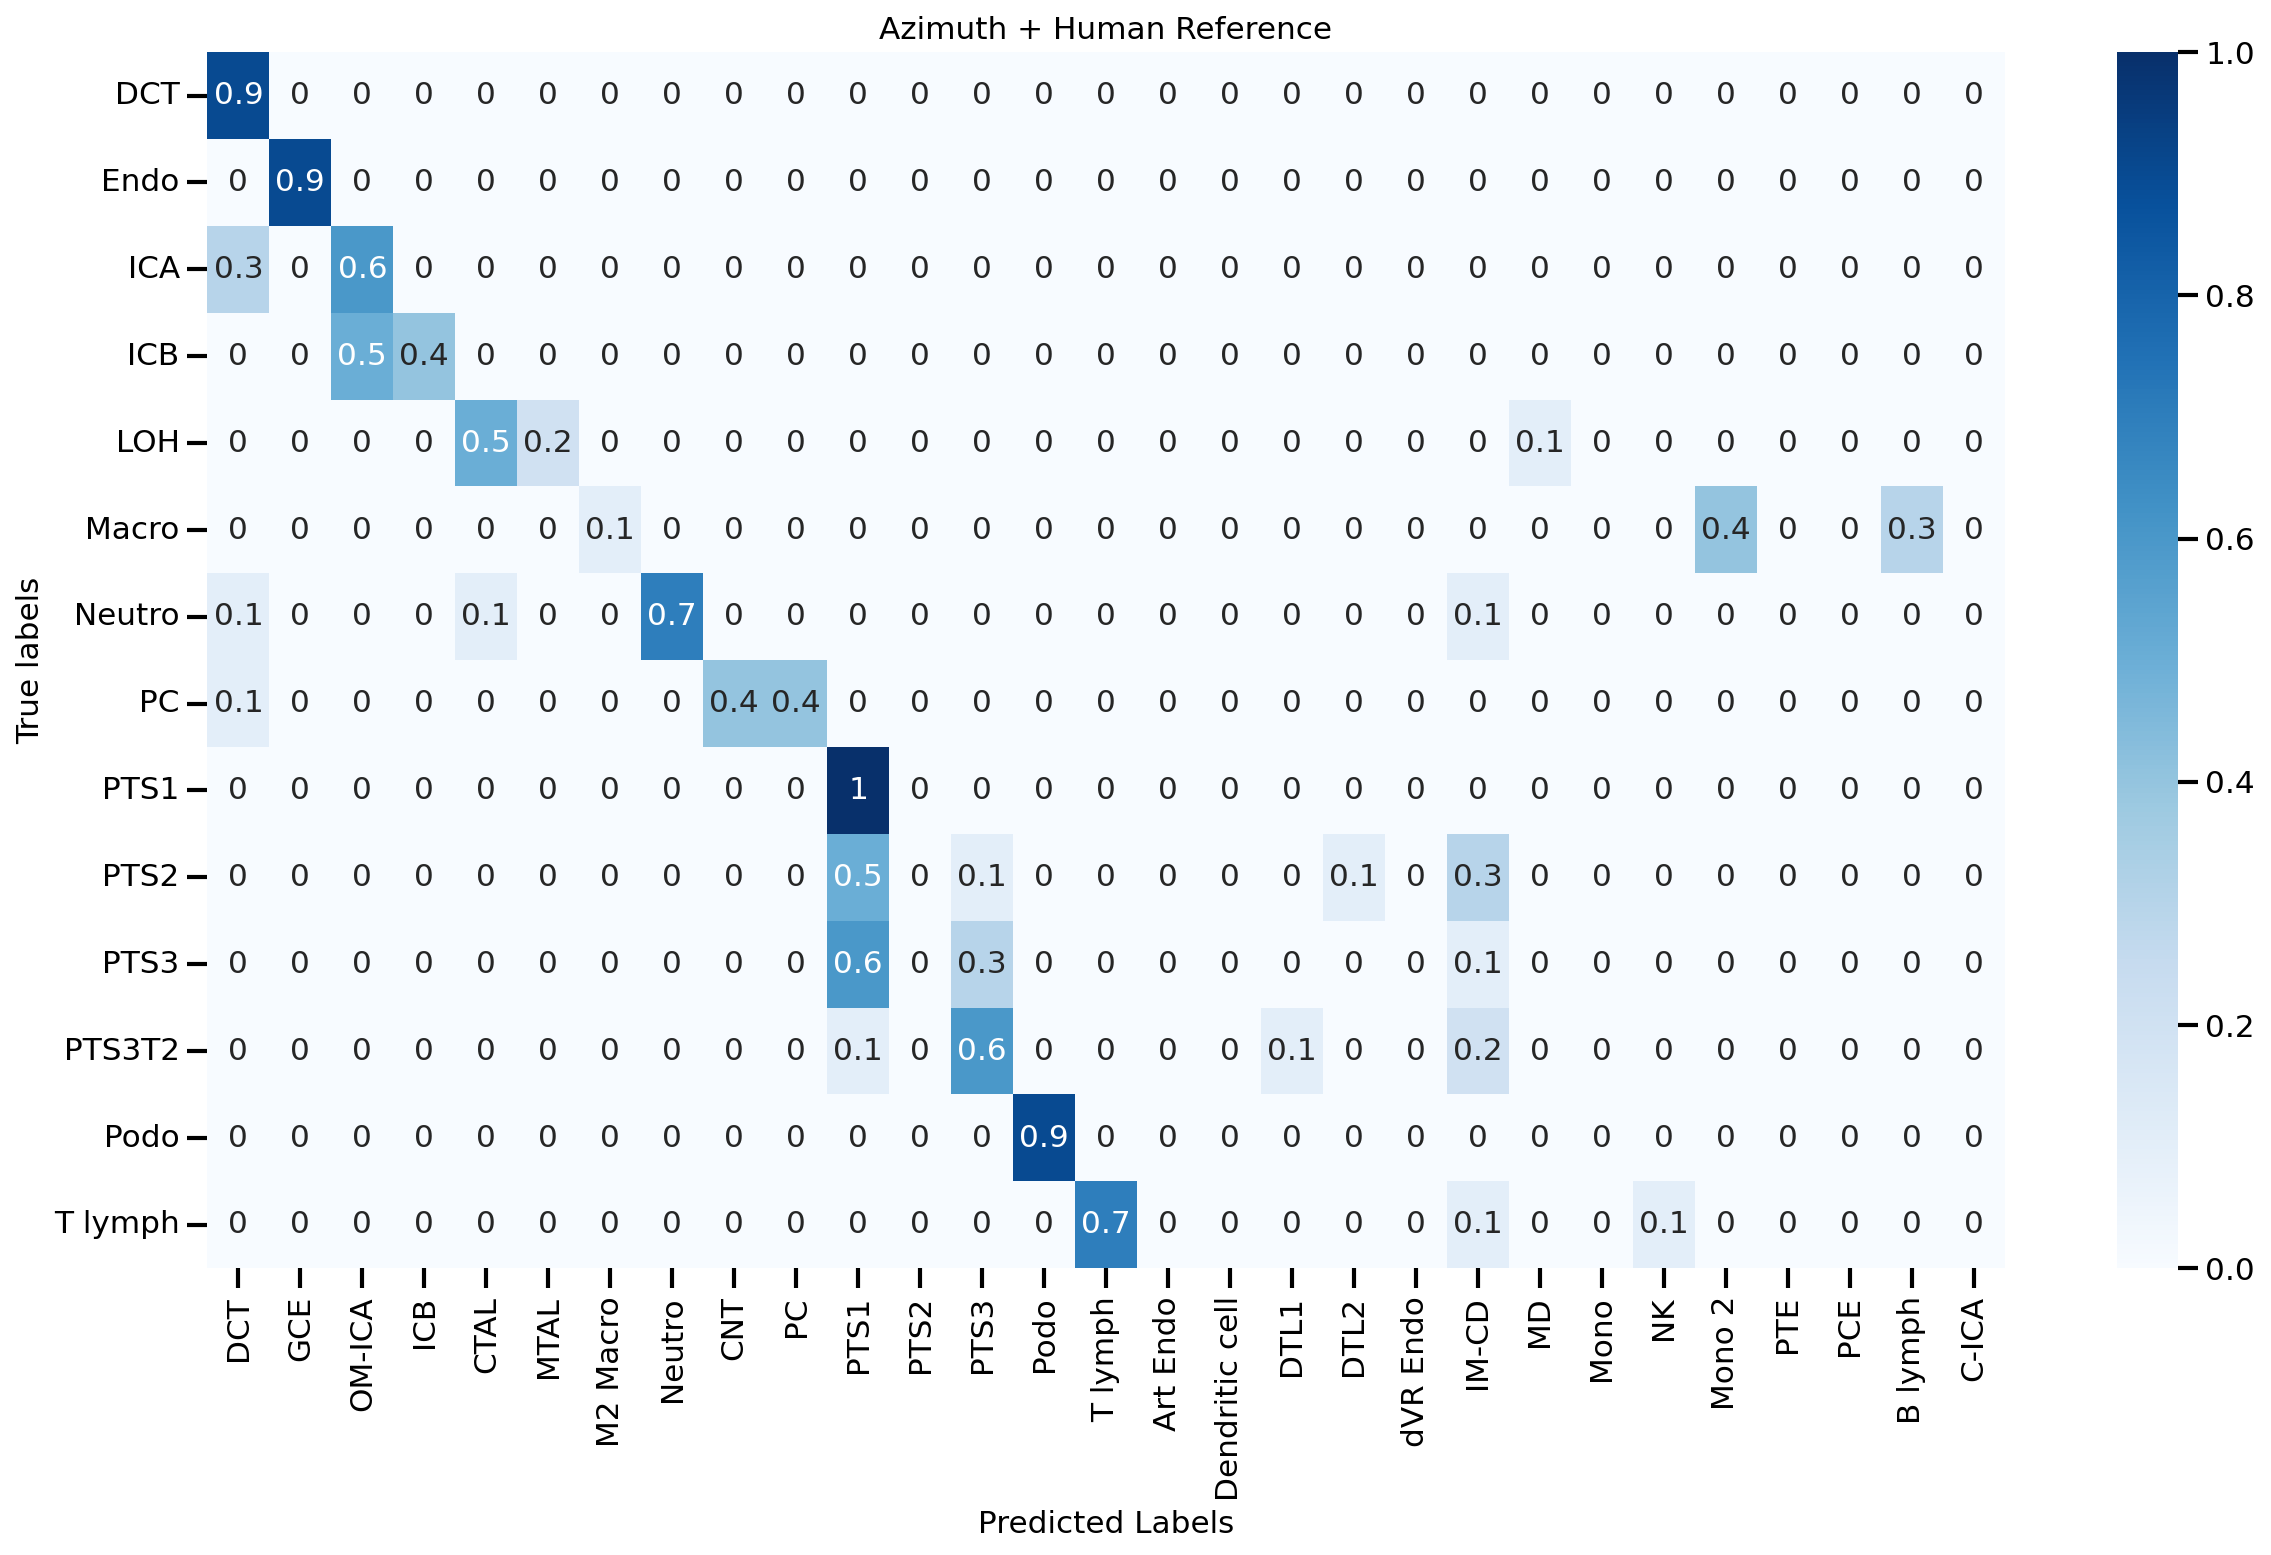

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
ax = sns.heatmap(round(confmatrix_az_hubmap,1), vmin = 0, vmax = 1, annot=True, cmap='Blues')
ax.set_title(label='Azimuth + Human Reference')
ax.set(xlabel='Predicted Labels', ylabel='True labels')
plt.savefig('confmatrix_Hubmap_Azimuth.svg')
plt.show()

 - scHPL

In [101]:
confmatrix_schpl.columns

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['ATL', 'B lymph', 'CD-Trans', 'CNT', 'CTAL', 'DCT', 'DCT-CNT', 'DTL',
       'DTL-ATL', 'Desc-Vasa-Recta', 'Endo', 'Glom-Endo', 'ICA', 'ICB', 'MD',
       'MTAL', 'Macro', 'NK', 'PC', 'PEC', 'PTS1', 'PTS2', 'PTS3', 'PTS3T2',
       'Podo', 'Rejected (RE)', 'Rejection (dist)', 'T lymph', 'Vas-Afferens',
       'root'],
      dtype='object', name='ypred')

In [124]:
column_order = ['DCT', 'DCT-CNT', 'Endo', 'Glom-Endo',   'ICA', 'ICB', 'CTAL', 'MTAL', 'Macro', 'B lymph',  'PC', 'CNT', 'PTS1', 'PTS2', 'PTS3', 'PTS3T2', 'Podo', 'T lymph', 'NK',  'DTL', 'CD-Trans', 'ATL', 'PEC',   'DTL-ATL','Desc-Vasa-Recta', 'Vas-Afferens','Rejected (RE)','Rejection (dist)',  'root']

In [125]:
confmatrix_schpl = confmatrix_schpl.reindex(columns=column_order)

In [126]:
new_index = confmatrix_schpl.index.to_series().str.split("-").str[0]
confmatrix_schpl.rename(index=new_index, inplace=True)

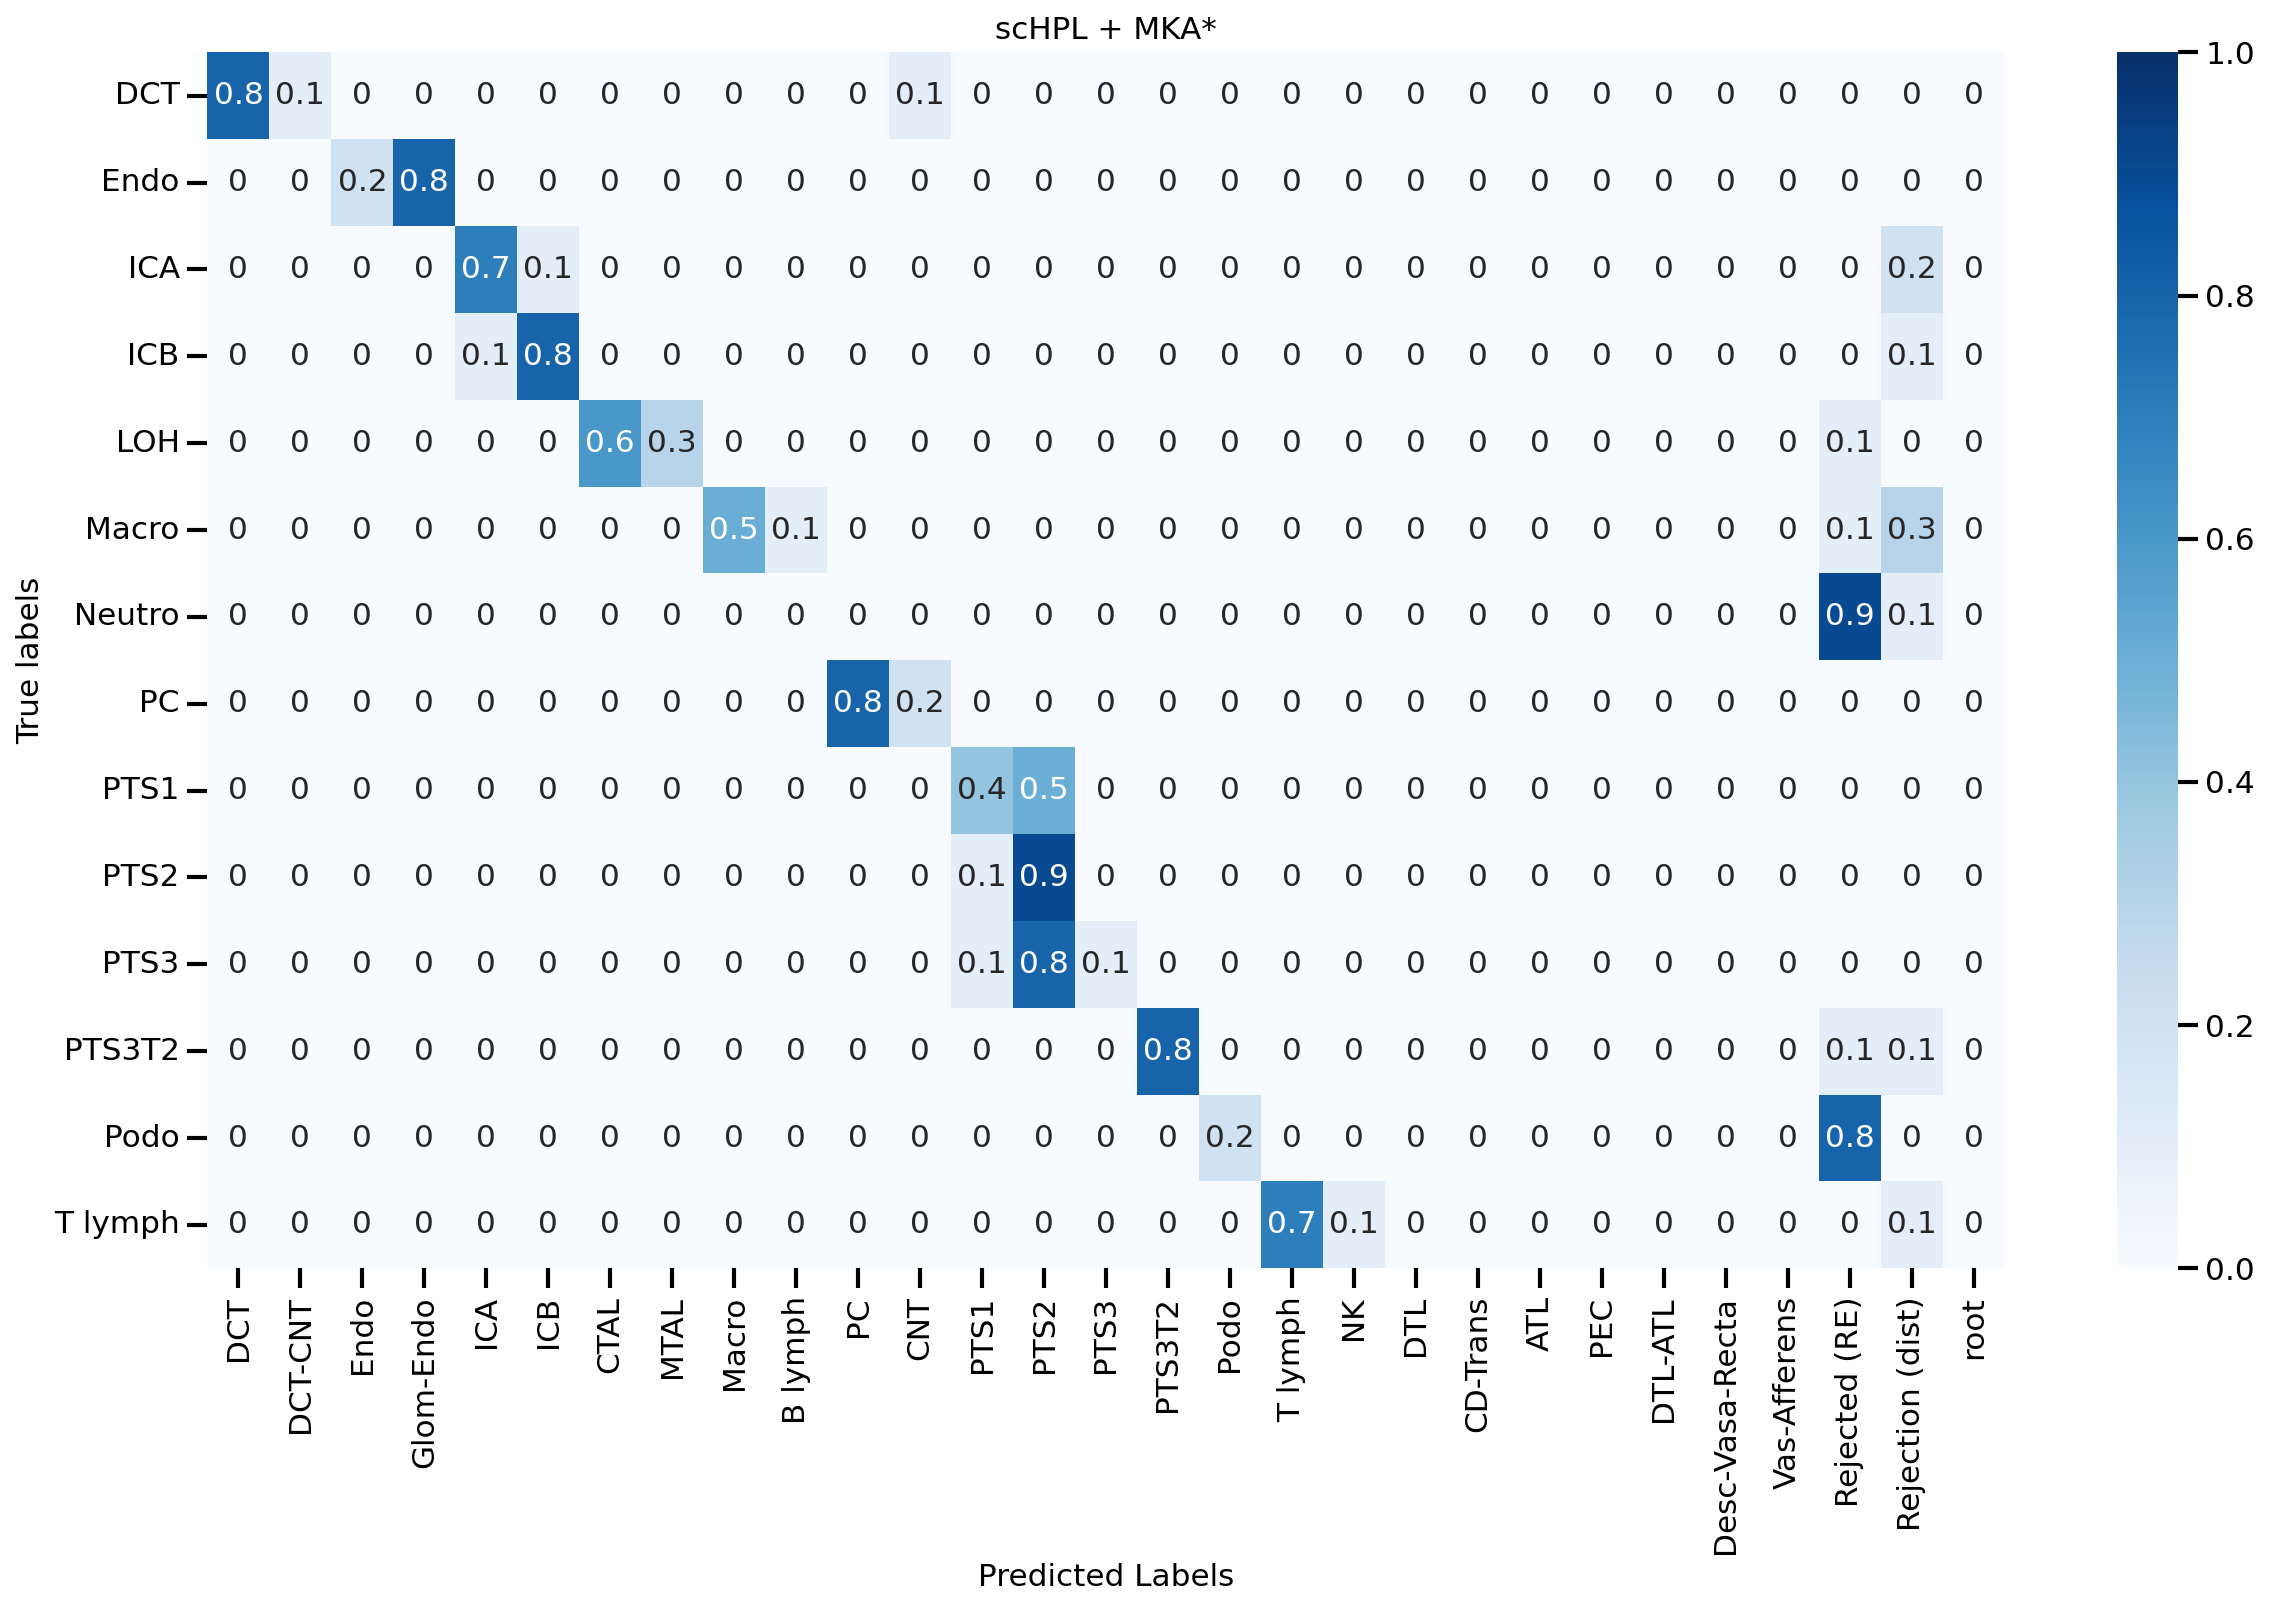

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
ax = sns.heatmap(round(confmatrix_schpl,1), vmin = 0, vmax = 1, annot=True, cmap='Blues')
ax.set_title(label='scHPL + MKA*')
ax.set(xlabel='Predicted Labels', ylabel='True labels')
plt.savefig('confmatrix_scHPL_knn.svg')
plt.show()

### UMAP visualization

In [188]:
atlas = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_int_curated_SCVI.h5ad")

In [189]:
atlas = atlas[atlas.obs.index.isin(list(miao_labels.index))].copy()

In [190]:
groups = atlas.obs.groupby('Origin').indices

In [191]:
evaluate_Miao = atlas[groups['Miao21']].copy()
reduce_adata(evaluate_Miao)

In [192]:
evaluate_Miao.obs['Predicted_scHPL'] = pred_labels_knn['cell_type']
evaluate_Miao.obs['Original'] = miao_labels['cell_type']
evaluate_Miao.obs['Predicted_Azimuth'] = azimuth_hubmap_labels['cell_type']
evaluate_Miao.obs['Predicted_Azimuth_atlas'] = azimuth_atlas_labels['cell_type']

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


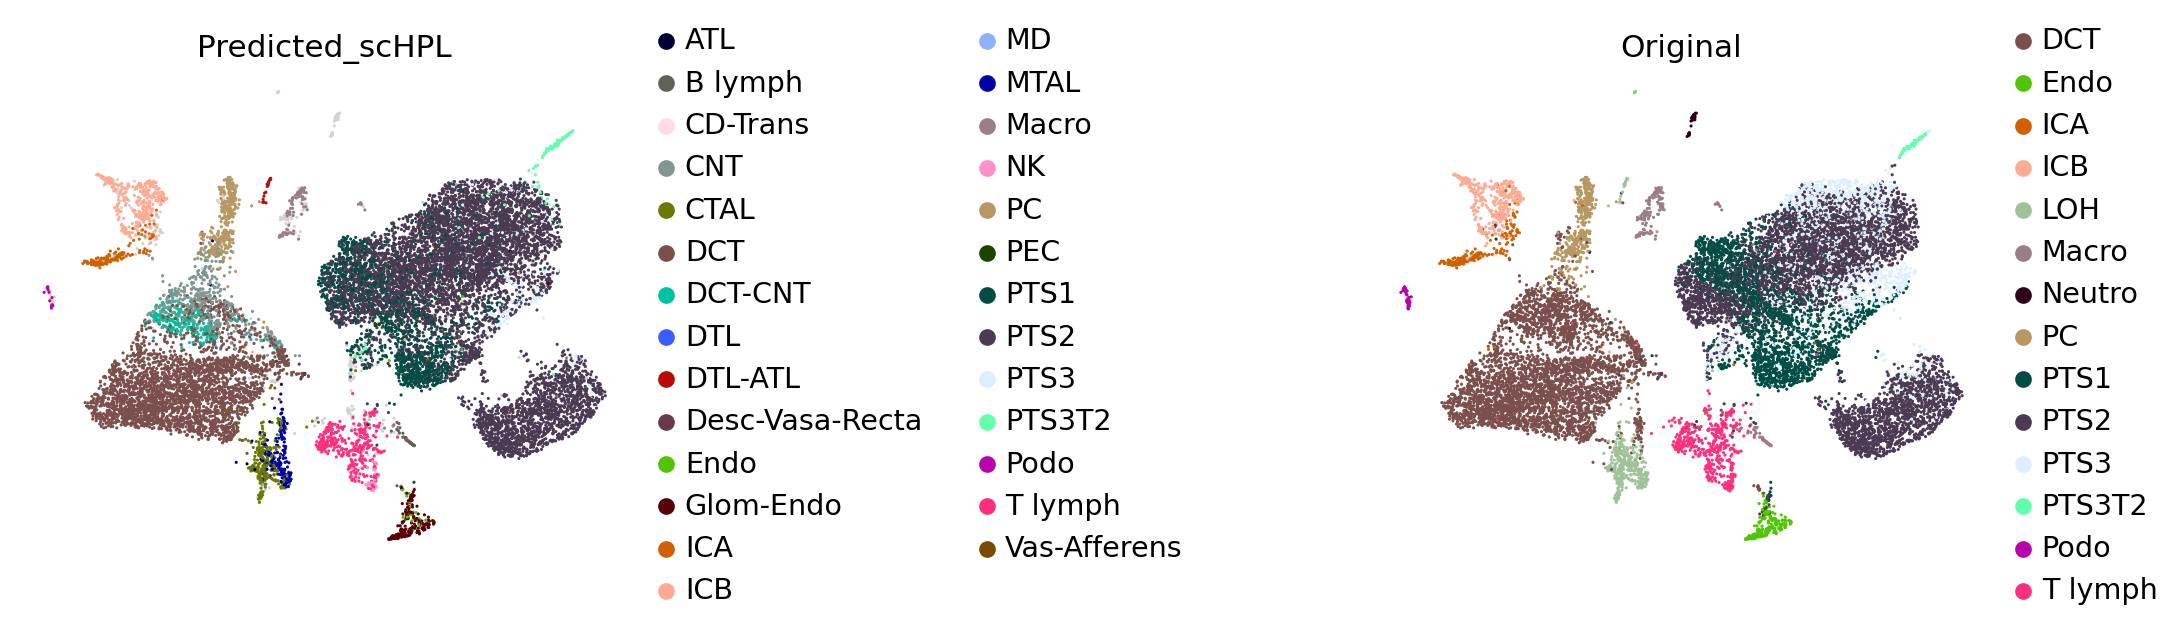

In [193]:
evaluate_Miao.obs['Predicted_scHPL'].replace({'root': np.nan, 'Rejection (dist)': np.nan, 'Rejected (RE)': np.nan}, inplace=True)
palette = {}
for n,i in enumerate(list(set(evaluate_Miao.obs['Predicted_scHPL'])) + ['LOH', 'Neutro']):
    palette[i] = sc.pl.palettes.default_102[n+6]
# palette['Rejected (RE)'] = 'grey'
# palette['Rejection (dist)'] = 'grey'
# palette['PTS3T2'] = '#A500FF'
# palette['Macro'] = '#77AAFF'
sc.pl.umap(evaluate_Miao, color=['Predicted_scHPL','Original'], palette=palette, na_in_legend=False, wspace=1)

In [194]:
palette

{nan: '#A30059',
 'CD-Trans': '#FFDBE5',
 'Vas-Afferens': '#7A4900',
 'MTAL': '#0000A6',
 'PTS3T2': '#63FFAC',
 'PC': '#B79762',
 'PTS1': '#004D43',
 'MD': '#8FB0FF',
 'Macro': '#997D87',
 'Glom-Endo': '#5A0007',
 'CNT': '#809693',
 'Desc-Vasa-Recta': '#6A3A4C',
 'PEC': '#1B4400',
 'Endo': '#4FC601',
 'DTL': '#3B5DFF',
 'PTS2': '#4A3B53',
 'T lymph': '#FF2F80',
 'B lymph': '#61615A',
 'DTL-ATL': '#BA0900',
 'CTAL': '#6B7900',
 'DCT-CNT': '#00C2A0',
 'ICB': '#FFAA92',
 'NK': '#FF90C9',
 'Podo': '#B903AA',
 'ICA': '#D16100',
 'PTS3': '#DDEFFF',
 'ATL': '#000035',
 'DCT': '#7B4F4B',
 'LOH': '#A1C299',
 'Neutro': '#300018'}

In [198]:
MiaoAnnotations = pd.read_csv('/exports/humgen/cnovellarausell/KidneyAtlas/annotations/Miao21P18_annotations.tsv', sep='\t', index_col=0, header=None)
MiaoAnnotations.rename(columns = {0: 'barcodes', 1: 'celltype'}, inplace=True)
MiaoAnnotations = MiaoAnnotations[~MiaoAnnotations.celltype.isin(['Proliferating', 'Unnamed', 'Early PT', 'NP'])]

In [212]:
new_index = MiaoAnnotations.index.to_series().str.cat(['-6-0']*len(MiaoAnnotations.index))
MiaoAnnotations.rename(index=new_index, inplace=True)

In [213]:
evaluate_Miao.obs['Original'] = MiaoAnnotations
Rename_Miao = {
'Stroma 1': 'Stroma',
'Stroma 2': 'Stroma',
'PC1': 'PC', 
'PC2': 'PC'
}
evaluate_Miao.obs['Original'] = evaluate_Miao.obs['Original'].replace(Rename_Miao)

In [214]:
evaluate_Miao.obs['Original']

barcode
AAACCTGAGAGTCGGT-6-0      IC
AAACCTGAGATAGCAT-6-0    Endo
AAACCTGAGCCAGGAT-6-0     PST
AAACCTGAGCCGCCTA-6-0     PST
AAACCTGAGTCTCAAC-6-0     PST
                        ... 
TTTGTCAGTTTGTGTG-6-0     PCT
TTTGTCATCGCTTGTC-6-0     PST
TTTGTCATCTAGAGTC-6-0     PST
TTTGTCATCTGGTTCC-6-0     PST
TTTGTCATCTGTTTGT-6-0     DCT
Name: Original, Length: 15325, dtype: object

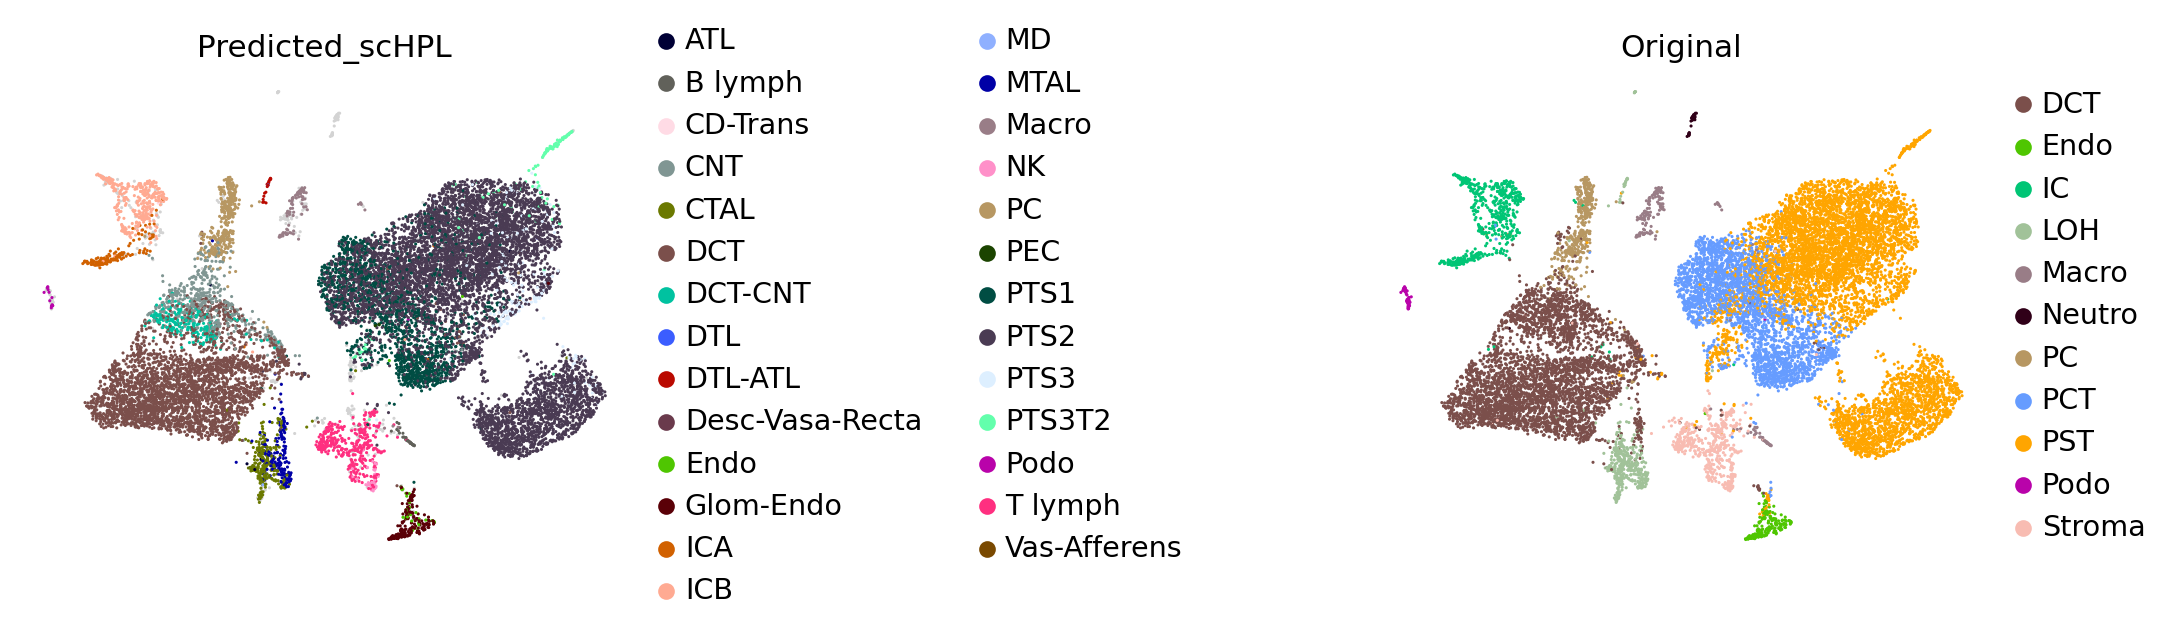

In [218]:
palette['IC'] = '#00c575'
palette['PST'] = '#FFA500'
palette['PCT'] = '#669cff'
palette['Stroma'] = '#f8bcb2'
sc.pl.umap(evaluate_Miao, color=['Predicted_scHPL','Original'], palette=palette, na_in_legend=False, wspace=1, save='schpl_original.svg')

- Azimuth hubmap

In [249]:
mapping = {
    'B': 'B lymph',
    'Glomerular Capillary Endothelial': 'GCE',
    'Afferent / Efferent Arteriole Endothelial': 'Art Endo',
    'Descending Vasa Recta Endothelial ': 'Desc-Vasa-Recta',
    'Classical Dendritic': 'Dendritic cell',
    'Connecting Tubule': 'CNT',
    'Cortical Collecting Duct Principal': 'PC',
    'Cortical Collecting Duct Intercalated Type A': 'C-ICA',
    'Cortical Thick Ascending Limb': 'CTAL',
    'Descending Thin Limb Type 1': 'DTL1',
    'Descending Thin Limb Type 2': 'DTL2',
    'Distal Convoluted Tubule': 'DCT',
    'Inner Medullary Collecting Duct': 'IM-CD',
    'Intercalated Type B': 'ICB',
    'M2 Macrophage': 'M2 Macro',
    'Macula Densa': 'MD',
    'Fibroblast': 'Fib',
    'Medullary Thick Ascending Limb': 'MTAL',
    'Monocyte-derived': 'Mono',
    'Non-classical monocyte': 'Mono 2',
    'Natural Killer T': 'NK',
    'Neutrophil': 'Neutro',
    'Outer Medullary Collecting Duct Intercalated Type A': 'OM-ICA',
    'Papillary Tip Epithelial': 'PTE',
    'Parietal Epithelial': 'PEC',
    'Peritubular Capilary Endothelial ': 'PCE',
    'Podocyte': 'Podo',
    'Proximal Tubule Epithelial Segment 1': 'PTS1',
    'Proximal Tubule Epithelial Segment 2': 'PTS2',
    'Proximal Tubule Epithelial Segment 3': 'PTS3',
    'Plasmacytoid Dendritic': 'Dendritic cell',
    'T': 'T lymph'}

In [250]:
evaluate_Miao.obs['Predicted_Azimuth'].replace(mapping, inplace=True)

In [254]:
palette

{nan: '#A30059',
 'CD-Trans': '#FFDBE5',
 'Vas-Afferens': '#7A4900',
 'MTAL': '#0000A6',
 'PTS3T2': '#63FFAC',
 'PC': '#B79762',
 'PTS1': '#004D43',
 'MD': '#8FB0FF',
 'Macro': '#997D87',
 'Glom-Endo': '#5A0007',
 'CNT': '#809693',
 'Desc-Vasa-Recta': '#6A3A4C',
 'PEC': '#1B4400',
 'Endo': '#4FC601',
 'DTL': '#3B5DFF',
 'PTS2': '#4A3B53',
 'T lymph': '#FF2F80',
 'B lymph': '#61615A',
 'DTL-ATL': '#BA0900',
 'CTAL': '#6B7900',
 'DCT-CNT': '#00C2A0',
 'ICB': '#FFAA92',
 'NK': '#FF90C9',
 'Podo': '#B903AA',
 'ICA': '#D16100',
 'PTS3': '#DDEFFF',
 'ATL': '#000035',
 'DCT': '#7B4F4B',
 'LOH': '#A1C299',
 'Neutro': '#300018',
 'IC': '#00c575',
 'PT': '#FFA500',
 'PST': '#FFA500',
 'PCT': '#669cff',
 'Stroma': '#f8bcb2'}

In [ ]:
set(evaluate_Miao.obs['Predicted_Azimuth']) - set(palette.keys())

{'Art Endo',
 'C-ICA',
 'DTL1',
 'DTL2',
 'Dendritic cell',
 'Fib',
 'GCE',
 'IM-CD',
 'M2 Macro',
 'Mono',
 'Mono 2',
 'OM-ICA',
 'PCE',
 'PTE'}

In [258]:
palette_az = palette
palette_az['C-ICA'] = '#D16100'
palette_az['GCE'] = '#5A0007'
palette_az['M2 Macro'] = '#997D87'
palette_az['OM-ICA'] = '#D16100'
palette_az['Missclassification'] = 'lightgrey'

In [261]:
mapping_CT = {
            'Art Endo': 'Misclassification',
             'DTL1': 'Misclassification',
             'DTL2': 'Misclassification',
             'Dendritic cell': 'Misclassification',
             'IM-CD': 'Misclassification',
             'M-Fib': 'Misclassification',
             'Mono': 'Misclassification',
             'Mono 2': 'Misclassification',
             'PCE': 'Misclassification',
             'PTE': 'Misclassification',
             'aVR Endo': 'Misclassification',
             'dVR Endo': 'Misclassification'}
evaluate_Miao.obs['Predicted_Azimuth'].replace(mapping_CT,inplace=True)

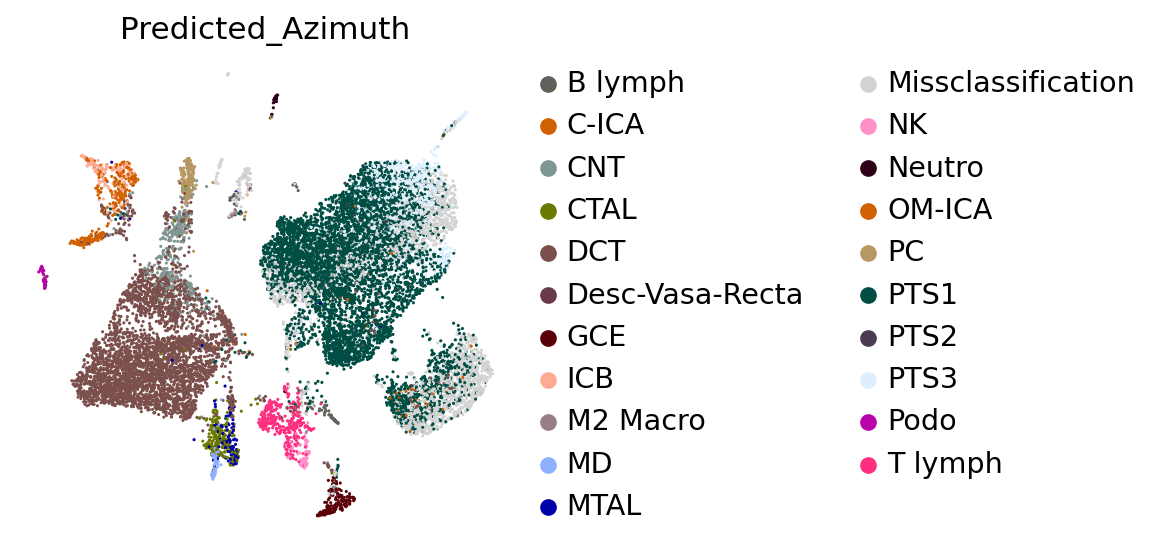

In [267]:
sc.pl.umap(evaluate_Miao, color=['Predicted_Azimuth'], palette=palette_az, na_in_legend=False, wspace=1, save='Azimuth_hubmap_v2.svg')

In [263]:
miss_azimuth = pd.DataFrame(evaluate_Miao[evaluate_Miao.obs['Predicted_Azimuth'] == 'Misclassification'].obs['Predicted_Azimuth'].value_counts())
miss_azimuth.to_csv("missclassified_azimuth.csv")

- Azimuth atlas

In [265]:
palette_az['DC'] = '#45776d'

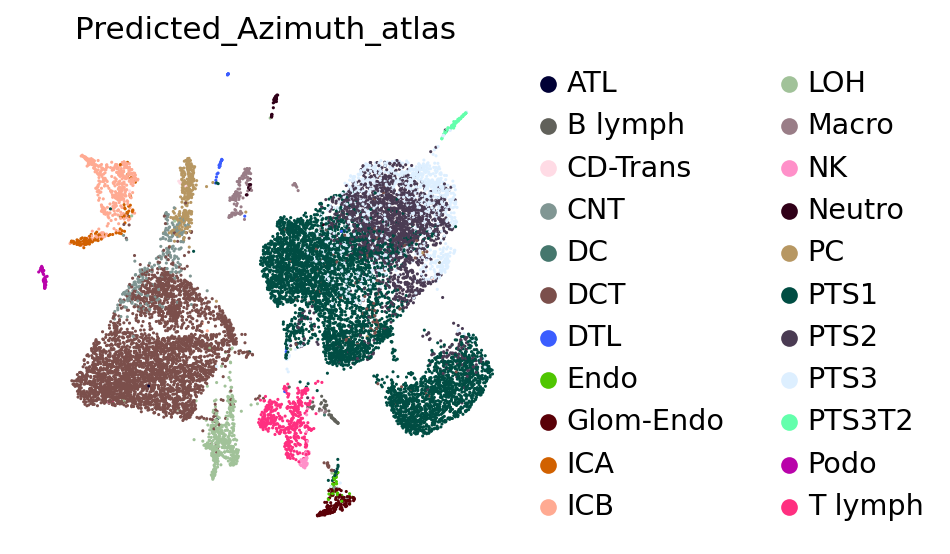

In [268]:
sc.pl.umap(evaluate_Miao, color=['Predicted_Azimuth_atlas'], palette=palette_az,  wspace=1, na_in_legend=False, save='Azimuth_atlas_v2.svg')

# Unlabeled datasets.

 Now let's process the individual datasets and plot the predicted celltypes

In [4]:
atlas = sc.read_h5ad("/exports/humgen/cnovellarausell/KidneyAtlas/h5ad/atlas_full_SCVI_annotated_v3.h5ad")

In [5]:
groups = atlas.obs.groupby('Origin').indices

In [6]:
atlas.obs['Predicted_Celltype_all'].replace({'Unknown': np.nan}, inplace=True)

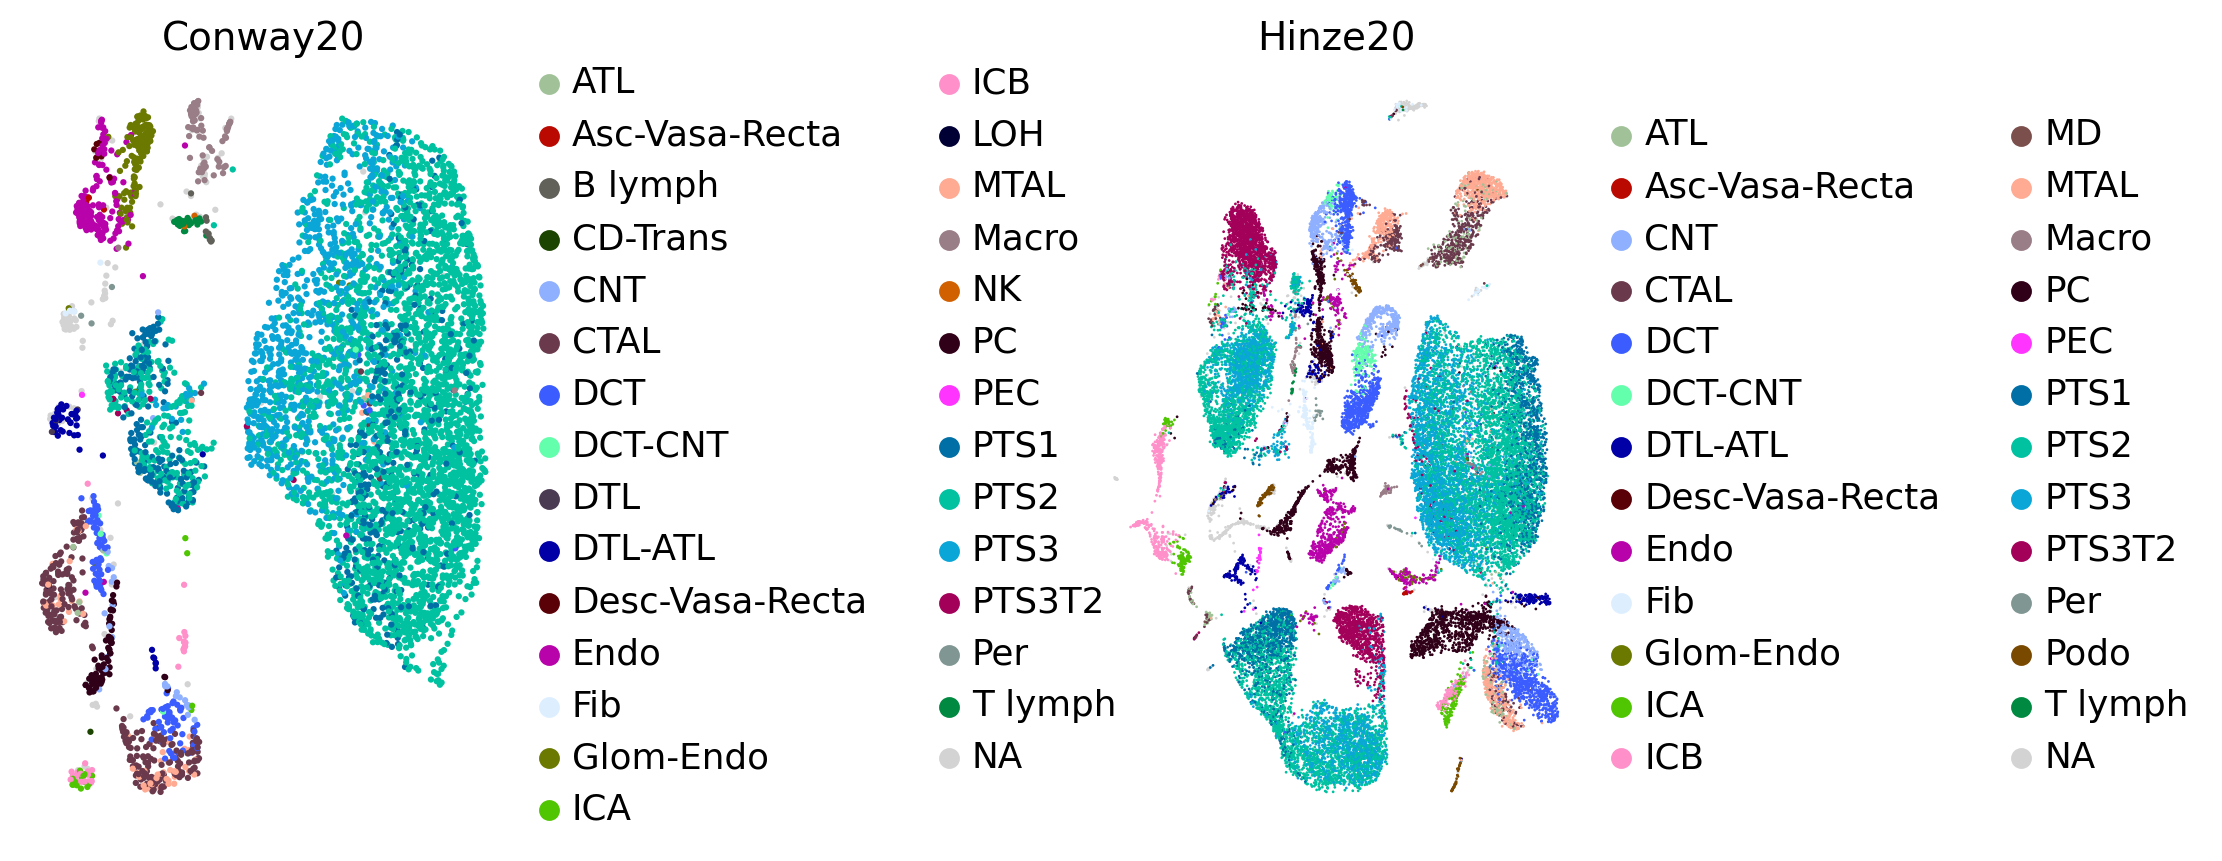

In [8]:
datasets = ['Conway20','Hinze20']
fig, axs, nrow, ncol = build_subplots(len(datasets))

if type(axs) != np.ndarray:
      axs = [axs]
else:
      axs = axs.ravel()

palette = {}
for n,i in enumerate(list(set(atlas.obs['Predicted_Celltype_all']))):
    palette[i] = sc.pl.palettes.default_102[n+1]
    
predicted_groups = {}
for (i,n) in zip(range(nrow*ncol), datasets):
      if i < len(datasets):
        predicted_groups[n] = atlas[groups[n]].copy()
        predicted_groups[n].raw = predicted_groups[n].copy()
        reduce_adata(predicted_groups[n])
        ax = sc.pl.umap(predicted_groups[n], color="Predicted_Celltype_all", ax=axs[i], show=False, palette=palette)
        ax.set(title='{}'.format(n))
fig.subplots_adjust(wspace = 1.2)
fig.show()        

In [276]:
fig.savefig("/exports/humgen/cnovellarausell/KidneyAtlas/notebooks/figures/dataset_plots_SCVI.svg")        

In [9]:
atlas.obs['Predicted_Celltype_all'].replace({np.nan: 'Unknown'}, inplace=True)

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
markers = {
    'All_PT': ['Slc34a1', 'Slc22a7'],
    'Podo': ['Nphs1', 'Nphs2'],
    'DTL': ['Slc14a2', 'Nr2e3'],
    'ATL': ['Clcnka'],
    'MTAL': ['Slc12a1', 'Umod'],
    'CTAL': ['Slc12a1', 'Egf'],
    'DCT': ['Slc12a3', 'Slc8a1'],
    'CNT': ['Aqp2'],
    'ICA': ['Slc4a1'],
    'ICB': ['Insrr'] ,
    'Endo': ['Adgrl4', 'Emcn']
}

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
predicted_groups['Conway20'].X

array([[-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317],
       [-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317],
       [-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317],
       ...,
       [-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317],
       [-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317],
       [-0.08090078, -0.04901567, -0.13870162, ..., -0.03194132,
        -0.06119617, -0.02084317]], dtype=float32)

In [34]:
[celltype for celltype in set(predicted_groups['Conway20'].obs['Predicted_Celltype_all']) if celltype in list(markers.keys())]

['CNT', 'CTAL', 'All_PT', 'ICA', 'DCT', 'DTL', 'MTAL', 'ICB', 'Endo', 'ATL']

In [35]:
predicted_groups['Conway20'][predicted_groups['Conway20'].obs['Predicted_Celltype_all'].isin([celltype for celltype in set(predicted_groups['Conway20'].obs['Predicted_Celltype_all']) if celltype in list(markers.keys())])]

View of AnnData object with n_obs × n_vars = 5281 × 16711
    obs: 'Celltype_Kirita', 'Origin', 'Source', 'Technology', 'Tissue_res', 'Age', 'Genetic_background', 'Gender', 'n_genes', 'Celltype_Park', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'batch', 'Celltype_Susztak', 'Celltype_Wu', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'Celltype_finest', 'Celltype_Dumas', 'Celltype_Janosevic', 'predicted_cells', 'Predicted_Celltype', 'Predicted_Celltype_all'
    var: 'mean', 'std'
    uns: 'Celltype_Kirita_colors', 'Celltype_Park_colors', 'Celltype_Susztak_colors', 'Predicted_Celltype_all_colors', 'Predicted_Celltype_colors', 'Technology_colors', 'predicted_cells_colors', 'pca', 'neighbors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 

In [37]:
cnw = predicted_groups['Conway20']

In [42]:
markers.keys()

dict_keys(['All_PT', 'Podo', 'DTL', 'ATL', 'MTAL', 'CTAL', 'DCT', 'CNT', 'ICA', 'ICB', 'Endo'])

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


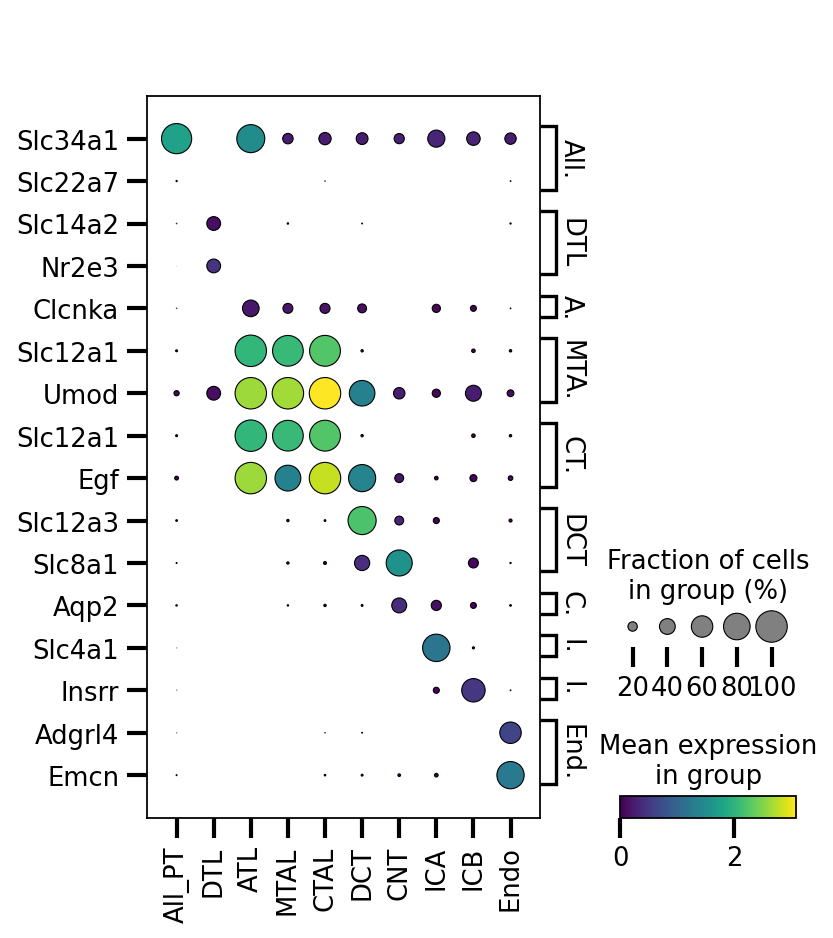

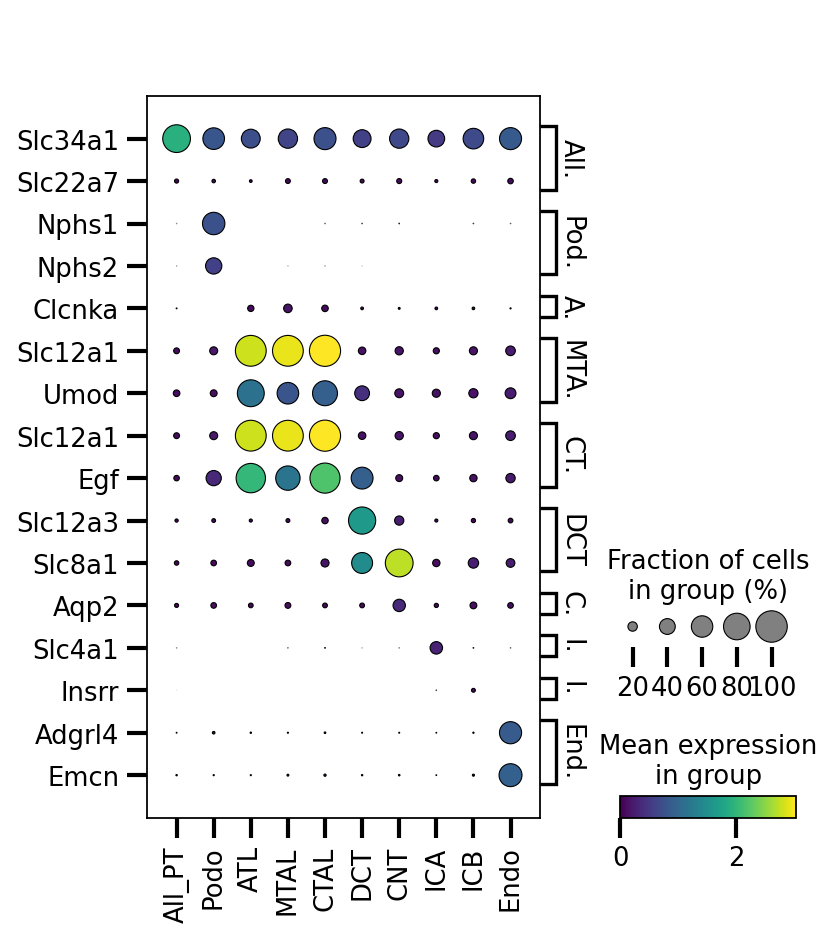

In [45]:
datasets = ['Conway20','Hinze20']

for dataset in datasets:
    predicted_groups[dataset].obs['Predicted_Celltype_all'].replace({'PTS1': 'All_PT', 'PTS2': 'All_PT', 'PTS3': 'All_PT' }, inplace=True)
    sc.pl.DotPlot(predicted_groups[dataset][predicted_groups[dataset].obs['Predicted_Celltype_all'].isin([celltype for celltype in set(predicted_groups[dataset].obs['Predicted_Celltype_all']) if celltype in list(markers.keys())])], {key: value for key, value in markers.items() if key in set(predicted_groups[dataset].obs['Predicted_Celltype_all'])}, use_raw=True,   groupby='Predicted_Celltype_all', var_group_rotation = 90,
                 categories_order = [celltype for celltype in list(markers.keys()) if celltype in set(predicted_groups[dataset].obs.Predicted_Celltype_all)]).style( dot_edge_color='black', dot_edge_lw=0.5, cmap='viridis').swap_axes().savefig('{}_markers.svg'.format(dataset))

In [5]:
atlas.obs['Predicted_Celltype_all'].replace({'PTS1': 'All_PT', 'PTS2': 'All_PT', 'PTS3': 'All_PT', 'PTS3T2': 'All_PT'}, inplace=True)

In [7]:
groups = atlas.obs.groupby('Origin').indices

In [8]:
datasets = ['Conway20','Hinze20']
l = []
for dataset in datasets:
    l.append((atlas[groups[dataset]].obs.Predicted_Celltype_all.value_counts() / len(atlas[groups[dataset]]) * 100).to_frame(name=dataset))
df = pd.concat(l,axis=1)
df.replace({np.nan: 0}, inplace=True)
df.index.name = 'Cell_type'
df.columns = pd.CategoricalIndex(data=df.columns, name='Study')

In [9]:
df = df.stack().reset_index()
df.columns = ['Cell_type', 'Study', 'Percentage']

In [10]:
df

Cell_type     Study  Percentage
0            All_PT  Conway20   77.973342
1            All_PT   Hinze20   62.927483
2              CTAL  Conway20    4.835954
3              CTAL   Hinze20    2.602498
4           Unknown  Conway20    2.785373
5           Unknown   Hinze20    3.681423
6              Endo  Conway20    2.648667
7              Endo   Hinze20    2.553456
8         Glom-Endo  Conway20    2.358168
9         Glom-Endo   Hinze20    0.264827
10              DCT  Conway20    2.204375
11              DCT   Hinze20    6.499706
12               PC  Conway20    1.281613
13               PC   Hinze20    6.339502
14            Macro  Conway20    1.196172
15            Macro   Hinze20    0.346564
16             MTAL  Conway20    1.110731
17             MTAL   Hinze20    3.877591
18          DTL-ATL  Conway20    0.768968
19          DTL-ATL   Hinze20    1.418950
20              ICB  Conway20    0.632262
21              ICB   Hinze20    1.706663
22          T lymph  Conway20    0.546822
23          T lymph   Hinze20    0.075198
24              CNT  Conway20    0.461381
25              CNT   Hinze20    3.380632
26              ICA  Conway20    0.307587
27              ICA   Hinze20    0.951416
28          B lymph  Conway20    0.187970
29          B lymph   Hinze20    0.000000
30  Desc-Vasa-Recta  Conway20    0.136705
31  Desc-Vasa-Recta   Hinze20    0.003269
32              ATL  Conway20    0.119617
33              ATL   Hinze20    0.866409
34              Fib  Conway20    0.085441
35              Fib   Hinze20    0.719283
36          DCT-CNT  Conway20    0.085441
37          DCT-CNT   Hinze20    0.918721
38   Asc-Vasa-Recta  Conway20    0.068353
39   Asc-Vasa-Recta   Hinze20    0.052312
40              DTL  Conway20    0.051265
41              DTL   Hinze20    0.000000
42              Per  Conway20    0.051265
43              Per   Hinze20    0.117701
44              LOH  Conway20    0.034176
45              LOH   Hinze20    0.000000
46               NK  Conway20    0.034176
47               NK   Hinze20    0.000000
48              PEC  Conway20    0.017088
49              PEC   Hinze20    0.124240
50         CD-Trans  Conway20    0.017088
51         CD-Trans   Hinze20    0.000000
52             Podo  Conway20    0.000000
53             Podo   Hinze20    0.549271
54               MD  Conway20    0.000000
55               MD   Hinze20    0.022886

/exports/humgen/cnovellarausell/conda_envs/atlas_work/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


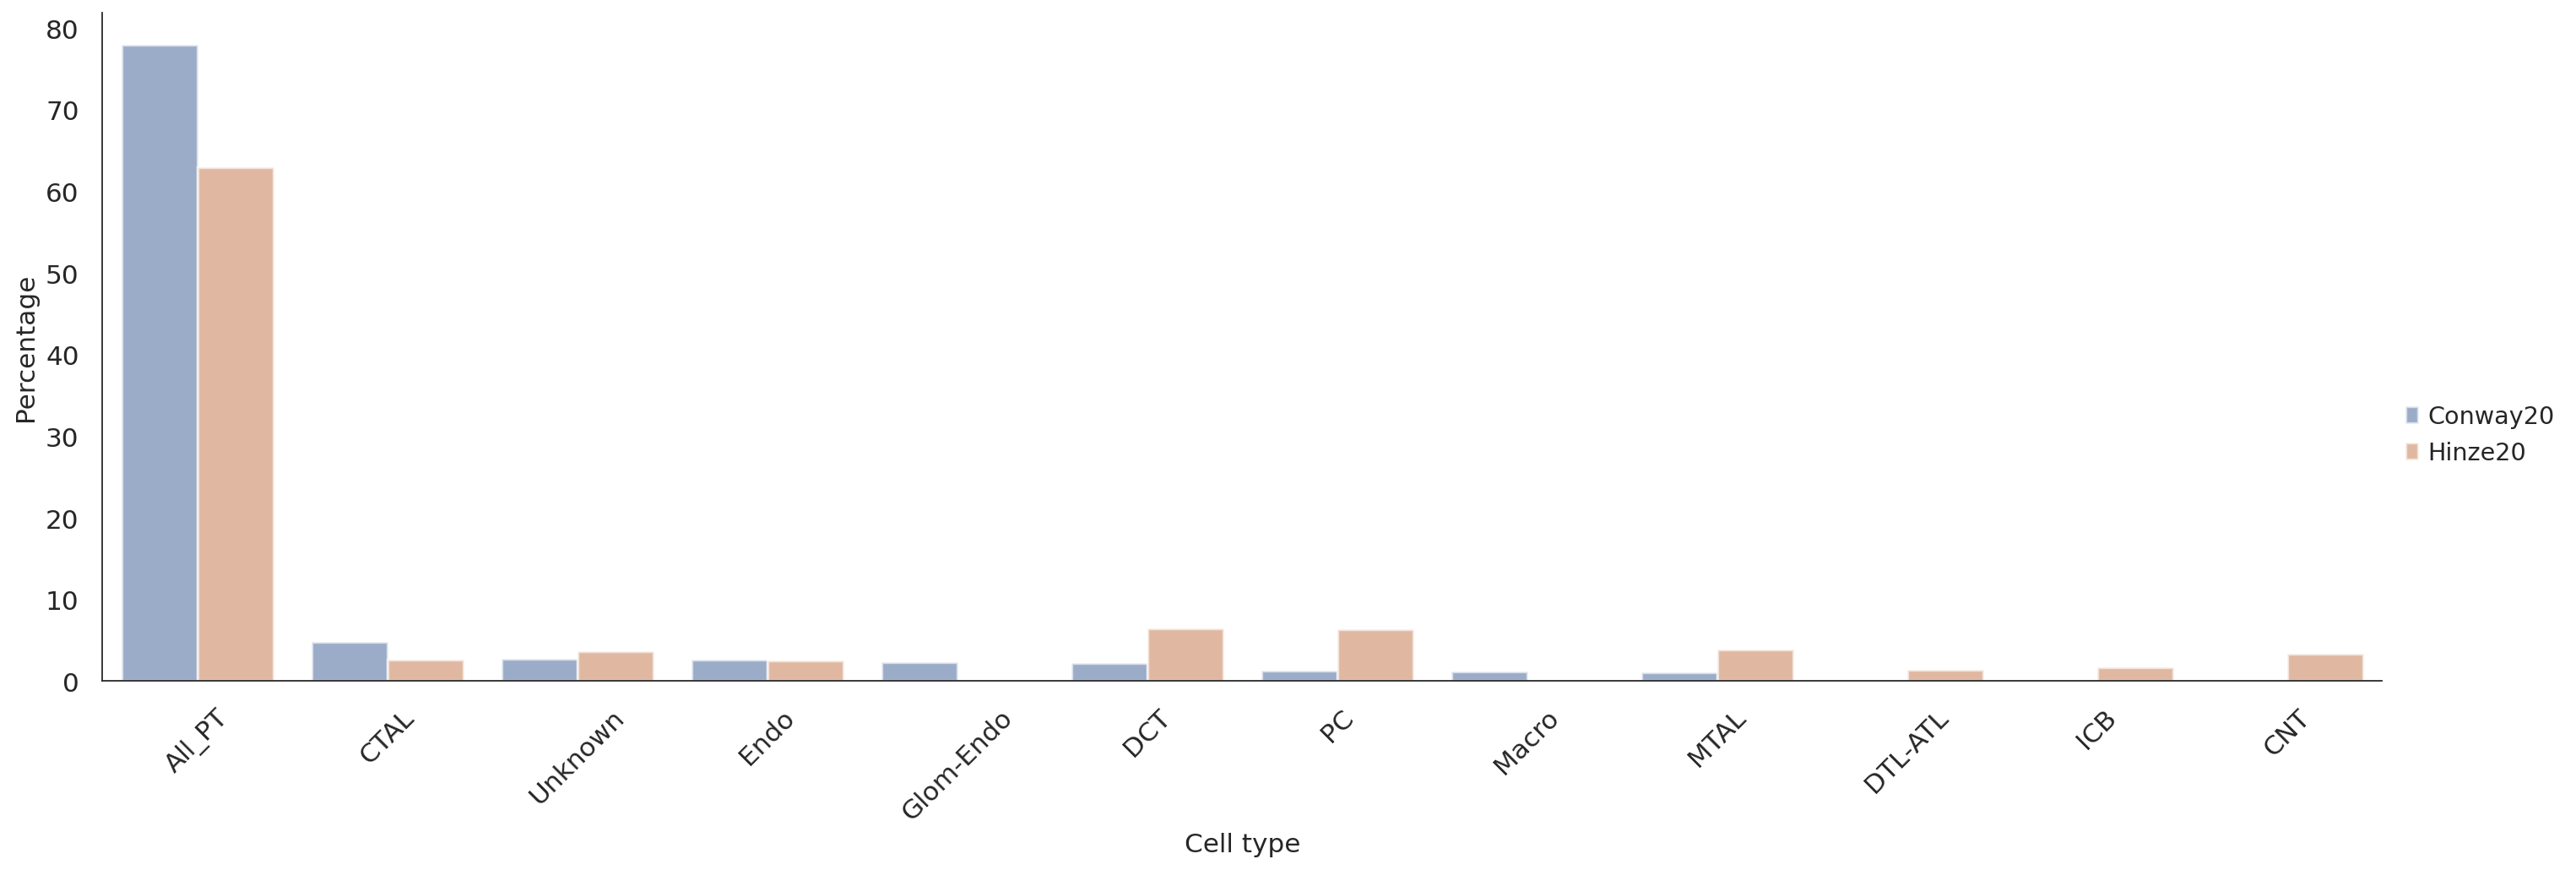

In [25]:
sns.set_style("white")

g = sns.catplot(
    data=df[df['Percentage'] >= 1], kind="bar",
    x="Cell_type", y="Percentage", hue="Study",
    ci="sd", palette='deep', alpha=.6, height=6, aspect=3
)
g.despine(left=True)
g.set_axis_labels("Cell type", 'Percentage')
plt.xticks(rotation=45)
g.legend.set_title("")
g.despine()
plt.savefig('Cell_percentages_predicted_SCVI.svg')